# This video is sponsored by ADA! An analysis of sponsorships on YouTube

## Table of Contents

1. [Imports](#Imports)
2. [Process Links in Video Descriptions](#Process-Links-in-Video-Descriptions) [see [videos_links.ipynb](processing/videos_links.ipynb)]
    1. [Extract Links from Video Descriptions](#Extract-Links-from-Video-Descriptions)
    2. [Analyse Shortened URLs](#Analyse-Shortened-URLs)
    3. [Resolve Shortened URLs](#Resolve-Shortened-URLs)
        1. [Resolve Bitly URLs](#Resolve-Bitly-URLs) [also see [resolve_bitly_links.ipynb](processing/resolve_bitly_links.ipynb)]
        2. [Resolve Google URLs](#Resolve-Google-URLs) [also see [resolve_google_links.ipynb](processing/resolve_google_links.ipynb)]
    4. [Resolve URLs in the Metadata Dataset](#Resolve-URLs-in-the-Metadata-Dataset)
3. [Detect Sponsorship Theme in Video Descriptions](#Detect-Sponsorship-Theme-in-Video-Descriptions) [see [videos_sponsorship.ipynb](processing/videos_sponsorship.ipynb)]
    1. [Define the Theme Detection Function](#Define-the-Theme-Detection-Function)
    2. [Apply the Theme Detection Function on the Dataset](#Apply-the-Theme-Detection-Function-on-the-Dataset)
    3. [Analyse the Sponsorship Scores](#Analyse-the-Sponsorship-Scores)
4. [Analyse and Classify Domains](#Analyse-and-Classify-Domains) [see [domains_analysis.ipynb](analysis/domains_analysis.ipynb)]
    1. [Broad Domain Analysis](#Broad-Domain-Analysis)
    2. [Domain Analysis on Popular Domains](#Domain-Analysis-on-Popular-Domains)
    3. [Classified Domains](#Classified-Domains)
    4. [Analyse Agencies](#Analyse-Agencies)
5. [Analyse Domains on Videos](#Analyse-Domains-on-Videos) [see [video_sponsors_analysis.ipynb](analysis/video_sponsors_analysis.ipynb)]
    1. [Domain Analysis on Popular Weighted Domains](#Domain-Analysis-on-Popular-Weighted-Domains)
6. [Network Analysis](#Network-Analysis) [see [network_analysis.ipynb](analysis/network_analysis.ipynb)]
    1. [Load the Data](#Load-the-Data)
    2. [Generate the Video-Sponsor Network](#Generate-the-Video-Sponsor-Network)
    3. [Generate the Sponsor-Sponsor Network](#Generate-the-Sponsor-Sponsor-Network)
    4. [Visualize the Networks](#Visualize-the-Networks)
7. [Add Features to the Metadata Dataset](#Add-Features-to-the-Metadata-Dataset) [see [videos_month_sponsors_fields.ipynb](processing/videos_month_sponsors_fields.ipynb)]
    1. [Add Sponsored Domains to Videos](#Add-Sponsored-Domains-to-Videos)
    2. [Add Months to Videos](#Add-Months-to-Videos)
8. [Analyse the Effect of Sponsors on Videos](#Analyse-the-Effect-of-Sponsors-on-Videos) [see [sponsored_videos_analysis.ipynb](analysis/sponsored_videos_analysis.ipynb)]
    1. [Analysis of Sponsored Categories](#Analysis-of-Sponsored-Categories)
    2. [Sponsored vs Non-Sponsored Videos](#Sponsored-vs-Non-Sponsored-Videos)
        1. [Bootstrap Analysis on Features](#Bootstrap-Analysis-on-Features)
        2. [T-tests on Sponsored Videos](#T-tests-on-Sponsored-vs-Non-Sponsored-Videos)
        3. [Matching Analysis on Sponsored Videos](#Matching-Analysis-on-Sponsored-Videos)
    3. [Agencied vs Non-Agencied Videos](#Agencied-vs-Non-Agencied-Videos)
        1. [Matching Analysis on Agencied Videos](#Matching-Analysis-on-Agencied-Videos)

## Imports

In [3]:
# FINDSPARK
import findspark
findspark.init()

# BASIC IMPORTS
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse

# NLTK
import nltk
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# PYSPARK
from pyspark.sql.functions import col, udf, explode, when, collect_list, lit
from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow when repartitioning.
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
USE_SUBDATASETS = False # Set to True to use the subdatasets, only for testing purposes.

PATH_METADATAS_SRC = './data/subdata/yt_metadata_en_sub' if USE_SUBDATASETS else './data/yt_metadata_en.jsonl'

## Process Links in Video Descriptions

This section processes links in video descriptions. Our goal is to extract URL domains that may be related to sponsors for each video, hence giving us a way to identify sponsorships in videos. The workflow is as follows:

1. We first load the metadata of all videos in the dataset and **extract the URLs from the description** of each video. URLs match a specific regular expression, which is defined in the `url_regex` variable. We only accept URLs that start with `http` or `https`, followed by a facultative `www.` and a mandatory domain name and path. Some URLs are already filtered given a non-exhaustive list of URLs that are not related to sponsors.

2. We then proceed on **analysing the shorten URLs**, which are short links redirecting to a specific URL. We are then able to **resolve most shortened URLs** using APIs provided by shortening services, or by using basic scraping techniques.

3. Finally, we put together the resolved URLs in the original dataset and **extract the domain names** from each URL. Each video now has a list of unique domains `domains`, a flag `has_domain` indicating whether the video has at least one domain, and a feature `domain_count` indicating the number of domains.

### Extract Links from Video Descriptions

Firstly, we extract links using regular expressions. We perform a first filtering to remove urls from sites that are generally not related to sponsors such as Youtube, Twitter, Facebook, Wikipedia, Discord, etc...

In [3]:
PATH_METADATAS_URLS_DST = './data/generated/yt_metadata_en_urls.parquet'

In [4]:
# Load the invalid URLs
PATH_INVALID_URLS = './data/invalid_urls.csv'

invalid_urls_reg = []
with open(PATH_INVALID_URLS, 'r') as f:
    for line in f:
        invalid_urls_reg.append(f"{line.strip()}")

In [5]:
def filter_invalid_urls(urls: list, filter_reg: list = None, match_start: bool = False, return_parsed: bool = False) -> list:
    """
    Filter invalid URLs from a list of URLs.
    
    
    Args:
        urls (list): The list of URLs.
        filter_reg (list): The list of regular expressions to filter the URLs.
        match_start (bool): If True, the regular expressions will be matched at the start of the URL.
        return_parsed (bool): If True, the function will return the parsed URLs (only the domain).

    Returns:
        list: The list of valid URLs.
    """
    
    new_urls = []
    for url in urls:

        # A url should start with https://, http:// or //
        if url.startswith("https://") or url.startswith("http://"):
            parsed_url = url
        else:
            parsed_url = "//" + url

        parsed_url = urlparse(parsed_url).netloc
        if parsed_url.startswith("www."):
            parsed_url = parsed_url[4:]  # Remove the 'www.' prefix

        match_reg = lambda reg: rf"(?i)(^{reg})" if match_start else rf"(?i)({reg})"
        if filter_reg is None or not any(
            re.search(match_reg(reg), parsed_url) for reg in filter_reg
        ):
            new_urls.append(parsed_url if return_parsed else url)

    return new_urls

# Parse works
assert filter_invalid_urls(
    ["https://www.special.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=False,
) == ["https://www.special.com/random"]
assert filter_invalid_urls(
    ["https://www.special.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=True,
) == ["special.com"]

# Parse still works on ill-formed URLs
assert filter_invalid_urls(
    ["youtube.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=False,
) == ["youtube.com/random"]
assert filter_invalid_urls(
    ["youtube.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=True,
) == ["youtube.com"]

# Regular expression filtering works
assert filter_invalid_urls(
    ["https://www.didnotexpect.youtube.com/random"],
    filter_reg=invalid_urls_reg,
    match_start=False,
    return_parsed=False,
) == []

# Match start works
assert filter_invalid_urls(
    ["https://www.didnotexpect.youtube.com/random"],
    filter_reg=invalid_urls_reg,
    match_start=True,
    return_parsed=True,
) == ["didnotexpect.youtube.com"]

In [6]:
def get_urls(description: str, filter_reg: list) -> list:
    """
    Extract URLs from a description.

    Args:
        description (str): The description.
        filter_reg (list): The list of regular expressions to filter the URLs.

    Returns:
        list: The list of URLs.
    """
    
    if description is None:
        return []
        
    url_regex = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    urls = []
    for line in description.split("\n"):
        if re.search(url_regex, line):
            urlss = [x.group() for x in re.finditer(url_regex, line)] # Find all urls in the line
            urlss = filter_invalid_urls(urlss, filter_reg=filter_reg, match_start=False, return_parsed=False)
            urls.extend(urlss)
    urls = list(set(urls)) # Remove duplicates
    return urls

# Test the function on basic examples
assert(get_urls('There is no link.', invalid_urls_reg) == [])
assert(get_urls('This is not a valid link: www.special.com/', invalid_urls_reg) == [])
assert(get_urls('This is a link: https://www.special.com/ and this is another link: https://www.youtube.com/watch?v=2', invalid_urls_reg) == ['https://www.special.com/'])
assert(get_urls('This is a link: https://www.special.com/ \n and this is an invalid link: www.special.com/', invalid_urls_reg) == ['https://www.special.com/'])

We then retrieve the raw links from the descriptions. The links are stored in the `urls` column as a list. The `urls_count` column contains the number of links retrieved in the description. The `has_urls` column is a boolean indicating whether the video has at least one link.

In [7]:
REPARTITION_SIZE = 500

schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])
    
metadatas = spark.read.json(PATH_METADATAS_SRC, schema=schema) \
    .repartition(REPARTITION_SIZE)

# Cast the dislike_count, like_count and view_count to their respective integer type
metadatas = metadatas \
    .withColumn("dislike_count", metadatas.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", metadatas.like_count.cast(IntegerType())) \
    .withColumn("view_count", metadatas.view_count.cast(LongType()))

# Get urls and count of urls in the description
get_urls_udf = udf(lambda x: get_urls(x, invalid_urls_reg), ArrayType(StringType()))
metadatas = metadatas.withColumn('urls', get_urls_udf(col('description')))
len_udf = udf(lambda x: len(x), IntegerType())
metadatas = metadatas.withColumn('urls_count', len_udf(col('urls')))
has_urls_udf = udf(lambda x: x > 0, BooleanType())
metadatas = metadatas.withColumn('has_urls', has_urls_udf(col('urls_count')))

# Drop the description and take only the videos with at least one url
metadatas_urls = metadatas.drop('description')

In [8]:
metadatas_urls.filter(metadatas_urls.has_urls).select('display_id', 'urls', 'urls_count').show()

+-----------+--------------------+----------+
| display_id|                urls|urls_count|
+-----------+--------------------+----------+
|t5bzcfU4Ja4|[http://bit.ly/ne...|         7|
|9li-TP3EgwA|[http://bit.ly/1u...|         2|
|QwLy7CracHM|[http://www.DexSt...|         1|
|A_tpoQmAItY|[https://goo.gl/M...|         1|
|vPqRay73oU4|[http://www.tinaa...|         1|
|IKmJUgHuS58|[http://www.tinaa...|         2|
|gZmqoJITXUk|[https://tinyurl....|         5|
|jBma-2qAgno|[http://www.media...|         5|
|r8exAxUKaV8|[http://tv.majorl...|         2|
|-WvCd7Dz_dc|[https://goo.gl/p...|         3|
|ccee5gmfrhI|[https://www.news...|         5|
|CPKuoJSxpH8|[http://mnot.es/2...|         6|
|zFfNZk0dhFA|[http://www.funny...|         4|
|_TzR3m0OAjA|[https://www.beas...|         1|
|hUnRd2UDwxA|[http://instagr.a...|         2|
|2ogho2nnLLk|[http://bit.ly/1Q...|         3|
|HXb1H9tIzQg|[http://bit.ly/2G...|        45|
|W_t04ggLUyo|[http://www.apple...|        12|
|ZUgConKxj6E|[http://www.tinaa...|

In [9]:
metadatas_urls.filter(~metadatas_urls.has_urls).select('display_id', 'urls', 'urls_count').show()

+-----------+----+----------+
| display_id|urls|urls_count|
+-----------+----+----------+
|qa0Fxs6T_wA|  []|         0|
|t3ysYv4Dusc|  []|         0|
|vIdRUnGhBT0|  []|         0|
|GCe3Lc9lg98|  []|         0|
|Y9Y9ZrAYdr8|  []|         0|
|svVtKZ0T9JM|  []|         0|
|mIj_S9MtB4M|  []|         0|
|Rw5ElxZet4E|  []|         0|
|ztaequSLOFU|  []|         0|
|mVPA3FdnfMc|  []|         0|
|jp8eETq3fcE|  []|         0|
|u1fErWi1Rvw|  []|         0|
|UHh_LoSQne4|  []|         0|
|G0CV8x5Ddj4|  []|         0|
|9BWLP49lgtQ|  []|         0|
|zg0BU41EBDM|  []|         0|
|-3Xpw8INjMk|  []|         0|
|YvGku9WHCPc|  []|         0|
|mheS7tLquys|  []|         0|
|EzCu6LqFJYY|  []|         0|
+-----------+----+----------+
only showing top 20 rows



In [10]:
metadatas_urls.dtypes

[('categories', 'string'),
 ('channel_id', 'string'),
 ('crawl_date', 'date'),
 ('dislike_count', 'int'),
 ('display_id', 'string'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('urls', 'array<string>'),
 ('urls_count', 'int'),
 ('has_urls', 'boolean')]

_Run the two cells below if you want to write the current state of the dataframe to a parquet file._

In [ ]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_URLS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_URLS_DST -Recurse -Force" # Windows

In [12]:
metadatas_urls.write.parquet(PATH_METADATAS_URLS_DST, partitionBy=['has_urls'], mode='overwrite')

### Analyse Shortened URLs

Links are often shortened using services such as Bitly, Google URL Shortener, etc... Unfortunately, they prevent us from knowing the actual destination of the link. We can however process them using scraping and other techniques to extract the actual destination. But first, let us see what are the most common services used to shorten links.

In [11]:
regs = {
    'bitly'     : r'https?:\/\/bit\.ly\/[a-zA-Z0-9\-\_]+',
    'google'    : r'https?:\/\/goo\.gl\/[a-zA-Z0-9\-\_]+',
    'tinyurl'   : r'https?:\/\/tinyurl\.com\/[a-zA-Z0-9\-\_]+',
    'adfly'     : r'https?:\/\/adf\.ly\/[a-zA-Z0-9\-\_]+',
    'owly'      : r'https?:\/\/ow\.ly\/[a-zA-Z0-9\-\_]+',
}

In [12]:
metadatas_shortened = metadatas_urls.select('*') # Copy the dataframe
# Add a column to count the number of urls per shortened url service
for short_name, short_reg in regs.items():
    reg_udf = udf(lambda x: len([y for y in x if re.search(short_reg, y)]), IntegerType())
    metadatas_shortened = metadatas_shortened.withColumn(short_name + '_count', reg_udf(col('urls')))

In [13]:
metadatas_shortened \
    .filter(metadatas_shortened.urls_count > 0) \
    .select('display_id', 'urls', 'bitly_count', 'google_count', 'tinyurl_count', 'adfly_count', 'owly_count') \
    .show()

+-----------+--------------------+-----------+------------+-------------+-----------+----------+
| display_id|                urls|bitly_count|google_count|tinyurl_count|adfly_count|owly_count|
+-----------+--------------------+-----------+------------+-------------+-----------+----------+
|-pXUD_ZnXdk|[http://www.thech...|          0|           0|            0|          0|         0|
|oQDC2_kKo_Y|[https://www.gofu...|          0|           0|            0|          0|         0|
|tWrmbz3VM10|[http://www.sigma...|          0|           0|            0|          0|         0|
|lxfd2tIRwf0|[http://www.Wirtz...|          0|           0|            0|          0|         0|
|zuY-2w0k1BI|[http://www.Micha...|          0|           0|            0|          0|         0|
|QjIDcAaN7dA|[http://www.tinaa...|          0|           0|            0|          0|         0|
|0NOz0zgPFVc|[http://bit.ly/1u...|          1|           0|            0|          0|         0|
|_5-WAqrqa5k|[https://gumroad.

In [14]:
# Get sum of short urls per shortener
short_urls_cnt = metadatas_shortened.select('bitly_count', 'google_count', 'tinyurl_count', 'adfly_count', 'owly_count') \
    .agg({'bitly_count': 'sum', 'google_count': 'sum', 'tinyurl_count': 'sum', 'adfly_count': 'sum', 'owly_count': 'sum'}) \
    .collect()[0] \
    .asDict()

# Get ratios of short urls per shortener
short_urls_total = sum(short_urls_cnt.values())
print(f'There are {short_urls_total:,} shortened urls in the dataset.\n')
for short_name, short_reg in regs.items():
    short_urls_ratio = short_urls_cnt[f'sum({short_name}_count)'] / short_urls_total
    print(f'{short_name} represents {short_urls_ratio:.2%} of the shortened urls.')

There are 52,710,312 shortened urls in the dataset.

bitly represents 55.15% of the shortened urls.
google represents 41.75% of the shortened urls.
tinyurl represents 2.58% of the shortened urls.
adfly represents 0.17% of the shortened urls.
owly represents 0.35% of the shortened urls.


In [15]:
n_urls = metadatas_shortened.select('urls_count').agg({'urls_count': 'sum'}).collect()[0].asDict()['sum(urls_count)']
n_urls

print(f'There are {n_urls:,} urls in the dataset. Shortened urls represent {short_urls_total / n_urls:.2%} of the urls.')

There are 141,054,862 urls in the dataset. Shortened urls represent 37.37% of the urls.


Note that these results do not assume that links are distinct. Bitly is the most common service used to shorten links, followed by Google URL Shortener. In the next sections, we will see how to extract the actual destination of links shortened by these two services.

### Resolve Shortened URLs

To further enrich our dataset, we resolve Bitly and Google shortened links.

In [8]:
def explode_outer(col: Column) -> Column:
    """
    Explode a column and keep null values.

    Args:
        col (Column): Column to explode.

    Returns:
        Column: Exploded column.
    """
    
    _explode_outer = sc._jvm.org.apache.spark.sql.functions.explode_outer 
    return Column(_explode_outer(_to_java_column(col)))

metadatas_resolved_urls = metadatas_urls.withColumn('url', explode_outer(col('urls')))

#### Resolve Bitly URLs

We write in a separate file all the Bitly URLs found in the dataset. We will then use various tools such as the Bitly API, or simple GET requests to resolve the URLs.

In [21]:
PATH_BITLY_URLS = './data/generated/bitly_urls.tsv'

In [10]:
# Delete the output folder if it already exists
#!rm -f $PATH_BITLY_URLS # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_BITLY_URLS -Recurse -Force" # Windows

In [11]:
# Get a dataframe with only the bitly urls
udf_retrieve_bitly_urls = udf(lambda x: [y for y in x if re.search(regs['bitly'], y)], ArrayType(StringType()))
bitly_urls = metadatas_urls \
    .filter(metadatas_urls.bitly_count > 0) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .select('url') \
    .distinct()

In [12]:
bitly_urls.write.csv(PATH_BITLY_URLS, sep='\t', header=False, mode='overwrite')

In [17]:
spark.read.csv(PATH_BITLY_URLS, sep='\t', header=False).count()

2597126

There are a total of $2'597'126$ distinct Bitly URLs in the dataset.

We now assume that the **Bitly URLs have been resolved** in a new tsv file named `bitly_resolved_urls` and we can replace them by their corresponding URLs. The notebook [resolve_bitly_links.ipynb](processing/resolve_bitly_links.ipynb) contains the code to resolve Bitly URLs.

In [9]:
PATH_BITLY_RESOLVED_URLS = './data/generated/bitly_resolved_urls.tsv'

In [10]:
schema = StructType([
    StructField("url",          StringType(), True),
    StructField("resolved_url", StringType(), True),
])
resolved_urls = spark.read.csv(PATH_BITLY_RESOLVED_URLS, sep='\t', header=False, schema=schema)

In [19]:
resolved_urls.show(5, False)

+----------------------+-----------------------------------------------------------------------------------------------------------------------+
|url                   |resolved_url                                                                                                           |
+----------------------+-----------------------------------------------------------------------------------------------------------------------+
|http://bit.ly/2CzkOZi |http://www.musicnotes.com/notes.asp?id=art_dario_daversa&url=http://www.musicnotes.com/sheetmusic/mtd.asp?ppn=MN0194860|
|https://bit.ly/2wRm722|https://www.audioadvice.com/martin-logan-dynamo-600x-subwoofer.html                                                    |
|http://bit.ly/2LqpROI |https://www.audioadvice.com/content/2018/05/23/klipsch-heritage-hp-3-heapdhones-review/                                |
|http://bit.ly/2rwI189 |https://www.audioadvice.com/cambridge-solo-phono-preamplifier.html                                        

In [11]:
# Join the bitly urls with the resolved urls
metadatas_resolved_urls = metadatas_resolved_urls.join(resolved_urls, on='url', how='leftouter')

In [21]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'FJMKM_TYLy8').select('display_id', 'url', 'resolved_url').show(5, False)

+-----------+----------------------------+------------------------------------------------------------------------+
|display_id |url                         |resolved_url                                                            |
+-----------+----------------------------+------------------------------------------------------------------------+
|FJMKM_TYLy8|http://NCS.lnk.to/Pyro      |null                                                                    |
|FJMKM_TYLy8|http://bit.ly/NCShardstyle  |http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnXJ2owag81mqSFklL83-d5 |
|FJMKM_TYLy8|http://bit.ly/ALLNCSmusic   |https://www.youtube.com/playlist?list=PLRBp0Fe2GpgnIh0AiYKh7o7HnYAej-5ph|
|FJMKM_TYLy8|http://bit.ly/DreadPittSC   |https://soundcloud.com/nocopyrightsounds/dread-pitt-pyro-ncs-release    |
|FJMKM_TYLy8|http://bit.ly/NCSdrumandbass|http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnzYdHtTCoBYPyIJG9_opMn |
+-----------+----------------------------+------------------------------

In [12]:
# Replace the bitly urls with the resolved urls if they exist
metadatas_resolved_urls = metadatas_resolved_urls \
    .withColumn('url', \
        when(metadatas_resolved_urls.resolved_url.isNotNull(), 
            metadatas_resolved_urls.resolved_url)
        .otherwise(
            metadatas_resolved_urls.url)) \
    .drop('resolved_url')

In [23]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'FJMKM_TYLy8').select('display_id', 'url').show(5, False)

+-----------+------------------------------------------------------------------------+
|display_id |url                                                                     |
+-----------+------------------------------------------------------------------------+
|FJMKM_TYLy8|http://NCS.lnk.to/Pyro                                                  |
|FJMKM_TYLy8|http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnXJ2owag81mqSFklL83-d5 |
|FJMKM_TYLy8|https://www.youtube.com/playlist?list=PLRBp0Fe2GpgnIh0AiYKh7o7HnYAej-5ph|
|FJMKM_TYLy8|https://soundcloud.com/nocopyrightsounds/dread-pitt-pyro-ncs-release    |
|FJMKM_TYLy8|http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnzYdHtTCoBYPyIJG9_opMn |
+-----------+------------------------------------------------------------------------+
only showing top 5 rows



#### Resolve Google URLs

We also write in a separate file all the Google shortened URLs found in the dataset, and retrieve their actual destination.

In [13]:
PATH_GOOGL_URLS = './data/generated/googl_urls.tsv'

In [10]:
# Delete the output folder if it already exists
#!rm -f $PATH_GOOGL_URLS # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_GOOGL_URLS -Recurse -Force" # Windows

In [11]:
# Get a dataframe with only the bitly urls
udf_retrieve_bitly_urls = udf(lambda x: [y for y in x if re.search(regs['google'], y)], ArrayType(StringType()))
googl_urls = metadatas_urls \
    .filter(metadatas_urls.google_count > 0) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .select('url') \
    .distinct()

In [12]:
googl_urls.write.csv(PATH_GOOGL_URLS, sep='\t', header=False, mode='overwrite')

In [14]:
spark.read.csv(PATH_GOOGL_URLS, sep='\t', header=False)

1397373

There are a total of $1'397'373$ distinct Google URLs in the dataset.

We now assume that the **Google URLs have been resolved** in a new tsv file named `googl_resolved_urls` and we can replace them by their corresponding URLs. The notebook [resolve_google_links.ipynb](processing/resolve_google_links.ipynb) contains the code to resolve Google URLs.

In [13]:
PATH_GOOGL_RESOLVED_URLS = './data/generated/googl_resolved_urls.tsv'

In [14]:
schema = StructType([
    StructField("url",          StringType(), True),
    StructField("resolved_url", StringType(), True),
])
resolved_urls = spark.read.csv(PATH_GOOGL_RESOLVED_URLS, sep='\t', header=False, schema=schema)

In [26]:
resolved_urls.show(5, False)

+---------------------+---------------------------------------------------------------------------+
|url                  |resolved_url                                                               |
+---------------------+---------------------------------------------------------------------------+
|https://goo.gl/izJQ3s|https://www.youtube.com/channel/UCzV3Xt_qXi8KaaBR58q-qFg?sub_confirmation=1|
|https://goo.gl/a3OBu7|https://shop.healthfulpursuit.com/product/balanced-keto-weekly-meal-plans/ |
|https://goo.gl/2V6uNV|https://business.facebook.com/goodwillentertainments                       |
|https://goo.gl/DYyb6n|https://www.facebook.com/GameDave                                          |
|https://goo.gl/XtDCt5|https://www.youtube.com/playlist?list=PLmNPLKPi9xyOdt80y51Q5O8XkhvZQ6N-V   |
+---------------------+---------------------------------------------------------------------------+
only showing top 5 rows



In [15]:
# Join the google urls with the resolved urls
metadatas_resolved_urls = metadatas_resolved_urls.join(resolved_urls, on='url', how='leftouter')

In [28]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'ddyzyVldG_4').select('display_id', 'url', 'resolved_url').show(5, False)

+-----------+---------------------+---------------------------------------------------------------------------------------------------------------------------------+
|display_id |url                  |resolved_url                                                                                                                     |
+-----------+---------------------+---------------------------------------------------------------------------------------------------------------------------------+
|ddyzyVldG_4|https://goo.gl/mk9DGY|https://www.audioadvice.com/shop-by-brand/sony/sony-es-receiver-lineup                                                           |
|ddyzyVldG_4|https://goo.gl/UdfFqB|https://www.audioadvice.com/videos-reviews/2017/06/13/sony-es-receiver-lineup-comparison-2017/                                   |
|ddyzyVldG_4|https://goo.gl/2YsUua|https://www.audioadvice.com/videos-reviews/2017/05/15/sony-str-za1100es-7-2-channel-4k-av-receiver-review/                       |
|ddy

In [16]:
# Replace the google urls with the resolved urls if they exist
metadatas_resolved_urls = metadatas_resolved_urls \
    .withColumn('url', \
        when(metadatas_resolved_urls.resolved_url.isNotNull(), 
            metadatas_resolved_urls.resolved_url)
        .otherwise(
            metadatas_resolved_urls.url)) \
    .drop('resolved_url')

In [30]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'ddyzyVldG_4').select('display_id', 'url').show(5, False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------+
|display_id |url                                                                                                                              |
+-----------+---------------------------------------------------------------------------------------------------------------------------------+
|ddyzyVldG_4|https://www.audioadvice.com/shop-by-brand/sony/sony-es-receiver-lineup                                                           |
|ddyzyVldG_4|https://www.audioadvice.com/videos-reviews/2017/06/13/sony-es-receiver-lineup-comparison-2017/                                   |
|ddyzyVldG_4|https://www.audioadvice.com/videos-reviews/2017/05/15/sony-str-za1100es-7-2-channel-4k-av-receiver-review/                       |
|ddyzyVldG_4|https://consent.youtube.com/ml?continue=https://www.youtube.com/channel/UCNNWgG-OiTQfvIE9cToLXdA?cbrd%3D1&gl=CH&hl=de&pc=yt

### Resolve URLs in the Metadata Dataset

Finally, we add the resolved URLs to the metadata dataset. We also extract the domain names from the URLs and add them to the dataset.

In [17]:
# Remove empty or none urls
metadatas_resolved_urls = metadatas_resolved_urls \
    .filter(metadatas_resolved_urls.url.isNotNull()) \
    .filter(metadatas_resolved_urls.url != '') \
    .filter(metadatas_resolved_urls.url != 'None')

In [18]:
# Aggregate back the urls together
metadatas_resolved_urls = metadatas_resolved_urls \
    .groupBy([c for c in metadatas_resolved_urls.columns if c != 'url' and c != 'urls']) \
    .agg(collect_list('url').alias('urls'))

Let us perform some sanity checks before continuing.

In [32]:
# There should be the same number of videos without urls
mu = metadatas_urls.filter(~metadatas_urls.has_urls)
mru = metadatas_resolved_urls.filter(~metadatas_resolved_urls.has_urls)

assert mu.count() == mru.count()

In [33]:
# There should be the same number of videos with urls
mu = metadatas_urls.filter(metadatas_urls.has_urls)
mru = metadatas_resolved_urls.filter(metadatas_resolved_urls.has_urls)

assert mu.count() == mru.count()

In [28]:
# Check that there are at least 95% of bitly urls resolved
udf_retrieve_bitly_urls = udf(lambda x: [y for y in x if re.search(r'https?:\/\/bit\.ly\/[a-zA-Z0-9\-\_]+', y)], ArrayType(StringType()))
mu = metadatas_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .count()
mru = metadatas_resolved_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .count()

assert mru / mu < 0.05
print(f'Out of {mu:,} Bitly links {mru:,} have not been resolved ({1 - mru / mu:.2%} resolved urls).')

Out of 29,070,539 Bitly links 1,412,474 have not been resolved (95.14% resolved urls).


In [22]:
# Check that there are at least 95% of Google urls resolved
udf_retrieve_googl_urls = udf(lambda x: [y for y in x if re.search(r'https?:\/\/goo\.gl\/[a-zA-Z0-9\-\_]+', y)], ArrayType(StringType()))
mu = metadatas_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_googl_urls(col('urls')))) \
    .count()
mru = metadatas_resolved_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_googl_urls(col('urls')))) \
    .count()

assert mru / mu < 0.05
print(f'Out of {mu:,} Google links {mru:,} have not been resolved ({1 - mru / mu:.2%} resolved urls).')

Out of 22,007,594 Google links 638,774 have not been resolved (97.10% resolved urls).


In [18]:
metadatas_resolved_urls.select('display_id', 'urls').show(20)

+-----------+--------------------+
| display_id|                urls|
+-----------+--------------------+
|wwR68kW1FGI|[http://3dextrude...|
|TZSErAPb41s|                  []|
|jZRNgLFK1yk|                  []|
|4QZ4tdIPGJQ|                  []|
|i8d1eBB_KSc|                  []|
|nZICMZEDgjA|[https://www.yout...|
|gd_L5HB_fVg|                  []|
|mZjn4Hc15PU|[http://integress...|
|iSNA-U4p1FY|[https://www.ebay...|
|sxs7zQchTAk|                  []|
|DrO5MnD4_9k|[https://www.what...|
|R9pdafTeekY|[http://whatcar.c...|
|ariBwkoMeFo|[https://www.yout...|
|3iHT_0yV9ZQ|[http://www.linyi...|
|5Ose6pPTnn8|[http://www.Giant...|
|UGs0QJ4lmQg|                  []|
|1jp6ps56XuM|                  []|
|vjOePT-s25Q|                  []|
|MNz1WmBhVNA|                  []|
|CnttoK_QpOM|                  []|
+-----------+--------------------+
only showing top 20 rows



In [19]:
# Parse the urls and find a list of distinct domains
parse_urls_udf = udf(lambda x: filter_invalid_urls(x, filter_reg=invalid_urls_reg, match_start=True, return_parsed=True), ArrayType(StringType()))
metadatas_resolved_urls = metadatas_resolved_urls \
    .withColumn('domains', parse_urls_udf(col('urls'))) \
    .drop('urls')

In [20]:
metadatas_resolved_urls.select('display_id', 'domains').show(20)

+-----------+--------------------+
| display_id|             domains|
+-----------+--------------------+
|wwR68kW1FGI|[3dextrude.weebly...|
|TZSErAPb41s|                  []|
|jZRNgLFK1yk|                  []|
|4QZ4tdIPGJQ|                  []|
|i8d1eBB_KSc|                  []|
|nZICMZEDgjA|                  []|
|gd_L5HB_fVg|                  []|
|mZjn4Hc15PU|[integress.tumblr...|
|iSNA-U4p1FY|[ebay.com, tiny.c...|
|sxs7zQchTAk|                  []|
|DrO5MnD4_9k|[whatcar.com, con...|
|R9pdafTeekY|[whatcar.com, con...|
|ariBwkoMeFo|[whatcar.com, wha...|
|3iHT_0yV9ZQ|[linyibrickmachin...|
|5Ose6pPTnn8|[GiantLinMachiner...|
|UGs0QJ4lmQg|                  []|
|1jp6ps56XuM|                  []|
|vjOePT-s25Q|                  []|
|MNz1WmBhVNA|                  []|
|CnttoK_QpOM|                  []|
+-----------+--------------------+
only showing top 20 rows



In [20]:
len_udf = udf(lambda x: len(x), IntegerType())
has_urls_udf = udf(lambda x: x > 0, BooleanType())

# Remove some useless features such as crawl_date and add features related to the domain
metadatas_resolved_urls = metadatas_resolved_urls \
    .drop('crawl_date') \
    .drop('urls_count') \
    .drop('has_urls') \
    .withColumn('domains_count', len_udf(col('domains'))) \
    .withColumn('has_domains', has_urls_udf(col('domains_count')))

In [ ]:
metadatas_resolved_urls.select('display_id', 'domains', 'domains_count', 'has_domains').show(20)

+-----------+--------------------+-------------+-----------+
| display_id|             domains|domains_count|has_domains|
+-----------+--------------------+-------------+-----------+
|wwR68kW1FGI|[3dextrude.weebly...|            1|       true|
|nZICMZEDgjA|                  []|            0|      false|
|iSNA-U4p1FY|[ebay.com, tiny.c...|           18|       true|
|BEjKBSLm2fc|[whatcar.com, the...|            3|       true|
|DrO5MnD4_9k|[whatcar.com, wha...|            2|       true|
|R9pdafTeekY|[whatcar.com, wha...|            3|       true|
|ariBwkoMeFo|[whatcar.com, wha...|            2|       true|
|3iHT_0yV9ZQ|[linyibrickmachin...|            1|       true|
|5Ose6pPTnn8|[GiantLinMachiner...|            1|       true|
|vAIO_wmAFTw|                  []|            0|      false|
|o70sRssdmv0|[hillclimbfans.co...|            2|       true|
|g-A8ovPMmB0|[teespring.com, m...|            2|       true|
|q7k10GAQay8|[iteachstamping.c...|            2|       true|
|bPyVUI4BzAo|     [letsd

Finally, we write the resulting dataset to a parquet file.

In [21]:
PATH_METADATAS_DOMAINS_DST = './data/generated/yt_metadata_en_domains.parquet'

In [22]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_DOMAINS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_DOMAINS_DST -Recurse -Force" # Windows

In [23]:
metadatas_resolved_urls.write.parquet(PATH_METADATAS_DOMAINS_DST, partitionBy=['has_domains'], mode='overwrite')

## Detect Sponsorship Theme in Video Descriptions

This section adds a new feature `sponsor_score` letting us know if a video description contains a sponsorship theme. 

When a video is sponsored, the description often contains a link to the sponsor's webside along with a short description of the product or service being promoted. Many of these descriptions are similar and contain the same keywords such as **sponsored**, **promotion** or **code**. To detect this, we perform the following:

1. For each video description, we tokenize the description, remove stop words and stem the remaining words.

2. From a list of keywords related to sponsorship, we create a list of stemmed keywords and count the number of words in the description that match the stemmed keywords. The keywords can be found in [sponsor_vocabulary.csv](data/sponsor_vocabulary.csv).

### Define the Theme Detection Function

Firstly, we define the function giving a score to a video description based on the appearance of keywords related to sponsorship.

In [3]:
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])
    
metadatas = spark.read.json(PATH_METADATAS_SRC, schema=schema)

In [4]:
# Load the stemmed keywords related to sponsorships
PATH_SPONSOR_VOCABULARY_SRC = './data/sponsor_vocabulary.csv'
sponsor_vocab = pd.read_csv(PATH_SPONSOR_VOCABULARY_SRC, header=None, encoding="utf-8").to_numpy().flatten()
sponsor_vocab = np.array([stemmer.stem(word) for word in sponsor_vocab])
sponsor_vocab

array(['sponsor', 'subscript', 'video', 'first', 'free', 'bonu', 'thank',
       'code', 'gift', 'discount', 'premium', 'coupon', 'deal', 'sale',
       'promo', 'pack', 'worldwid', 'ship', 'includ', 'limit', 'stock',
       'avail', 'trial', 'offer', 'money', 'annual', 'month', 'monthli',
       'week', 'weekli', 'day', 'daili', 'today', 'off', 'onli', 'now',
       'extra', 'here', 'save', 'order', 'tri', 'use', 'download',
       'purchas', 'shop', 'buy', 'get', 'unlimit', '$'], dtype='<U9')

In [5]:
def get_sponsor_score(description: str) -> int:
    """
    Returns the number of times a word from the sponsor vocabulary appears in the description.

    Args:
        description (str): The description of the video.
    
    Returns:
        int: The sponsor score, i.e. the number of times a word from the sponsor vocabulary appears in the description.
    """
    
    if description is None:
        return 0

    # Tokenize
    tokens = word_tokenize(description)
    # Remove stop words
    tokens = [word.lower() for word in tokens if word not in stop_words]
    # Stemming
    if stemmer is not None:
        tokens = [stemmer.stem(word) for word in tokens]
    score = sum(1 for word in tokens if word in sponsor_vocab)

    return score
    

Below are two examples of video descriptions. The first one is sponsored, having a score of $16$. This is greater than the score of the second video description, which is not sponsored.

In [6]:
str1 = "Try out my quantum mechanics course (and many others on math and science) on https://brilliant.org/sabine. You can get started for free, and the first 200 will get 20% off the annual premium subscription.\n\nToday we’ll talk about how to build a radio telescope – on the moon, recent wormhole headlines, the Artemis 1 launch and why it was delayed, quantum microscopes and the status of quantum computing, the first metaverse nation, manta rays, advances in material design, the link between chaos and biodiversity. And of course, the telephone will ring.\n\n👉 Transcript and references on Patreon ➜ https://www.patreon.com/Sabine\n💌 Sign up for my weekly science newsletter. It's free!  ➜ https://sabinehossenfelder.com/newsle...\n📖 My new book \"Existential Physics\" is now on sale ➜ http://existentialphysics.com/\n🔗 Join this channel to get access to perks ➜ https://www.youtube.com/channel/UC1yN...\n\n00:00 Intro\n00:35 Plans For a Radio-Telescope on the Moon\n02:31 Are Black Holes Wormholes?\n04:12 Why the Delays With the Artemis 1 Launch?\n06:00 Prototype of a Quantum Microscope\n07:25 Still No Useful Quantum Advantage\n08:34 Big Population of Manta Rays Found\n10:00 The First Metaverse Nation\n11:36 Progress in Material Science\n12:41 Chaos in the Evolution of a Single Species\n13:25 Check Out My Quantum Mechanics Course\n\n#science #sciencenews"
print(str1)

Try out my quantum mechanics course (and many others on math and science) on https://brilliant.org/sabine. You can get started for free, and the first 200 will get 20% off the annual premium subscription.

Today we’ll talk about how to build a radio telescope – on the moon, recent wormhole headlines, the Artemis 1 launch and why it was delayed, quantum microscopes and the status of quantum computing, the first metaverse nation, manta rays, advances in material design, the link between chaos and biodiversity. And of course, the telephone will ring.

👉 Transcript and references on Patreon ➜ https://www.patreon.com/Sabine
💌 Sign up for my weekly science newsletter. It's free!  ➜ https://sabinehossenfelder.com/newsle...
📖 My new book "Existential Physics" is now on sale ➜ http://existentialphysics.com/
🔗 Join this channel to get access to perks ➜ https://www.youtube.com/channel/UC1yN...

00:00 Intro
00:35 Plans For a Radio-Telescope on the Moon
02:31 Are Black Holes Wormholes?
04:12 Why th

In [7]:
score1 = get_sponsor_score(str1)
print(f"The sponsorhip score is {score1}.")

The sponsorhip score is 16.


In [8]:
str2 = "All rise for the most iconic housewife, heiress of Hilton Hotels & mother of queen Paris Hilton 👑💖\n\n☆ MY MERCH SHOP: \n☆ https://teespring.com/stores/offensiv... \n\nMY INSTAGRAM: @offensivetea.yt \nhttps://www.instagram.com/offensivete... \n\nBACK-UP ACCOUNT:\nhttps://www.youtube.com/channel/UCgds... \n\nPATREON:\nhttps://www.patreon.com/offensivetea \n\nLooking for missing copyrighted videos? They're probably on my Vimeo page!\nhttps://vimeo.com/offensivetea\n\n\nBUSINESS ONLY:\noffensivetea@hotmail.com\n\n\n\n#RHOBH #kathyhilton #housewives #iconic #offensivetea #meme #parishilton #funnymoments #stantwitter #edit"
print(str2)

All rise for the most iconic housewife, heiress of Hilton Hotels & mother of queen Paris Hilton 👑💖

☆ MY MERCH SHOP: 
☆ https://teespring.com/stores/offensiv... 

MY INSTAGRAM: @offensivetea.yt 
https://www.instagram.com/offensivete... 

BACK-UP ACCOUNT:
https://www.youtube.com/channel/UCgds... 

PATREON:
https://www.patreon.com/offensivetea 

Looking for missing copyrighted videos? They're probably on my Vimeo page!
https://vimeo.com/offensivetea


BUSINESS ONLY:
offensivetea@hotmail.com



#RHOBH #kathyhilton #housewives #iconic #offensivetea #meme #parishilton #funnymoments #stantwitter #edit


In [9]:
score2 = get_sponsor_score(str2)
print(f"The sponsorhip score is {score2}.")

The sponsorhip score is 3.


### Apply the Theme Detection Function on the Dataset

We apply the function on the dataset and save the results in a new column `sponsor_score`.

In [10]:
get_sponsor_score_udf = udf(get_sponsor_score, IntegerType())
metadatas_sponsor_scores = metadatas \
    .withColumn('sponsor_score', get_sponsor_score_udf(metadatas.description)) \
    .cache() \
    .select('display_id', 'sponsor_score')

In [12]:
metadatas_sponsor_scores.show()

+-----------+-------------+
| display_id|sponsor_score|
+-----------+-------------+
|SBqSc91Hn9g|            2|
|UuugEl86ESY|            1|
|oB4c-yvnbjs|            2|
|ZaV-gTCMV8E|            2|
|cGvL7AvMfM0|            3|
|iVADSRjaLtQ|            2|
|ypVcK9mldPc|            1|
|qA1NayP9cNY|            2|
|CWdSl9ta4Rg|            1|
|64dCTkxCHpY|            2|
|rU2iDhVd-bI|            2|
|y5IvyZlzELs|            1|
|riSUG1R4Ckw|            1|
|C_dN36VjbZA|            2|
|E_cfDMDd0YM|            1|
|zuwQeKIhp2o|            2|
|dzcd5pen7Cw|            2|
|qYLAxjuoDtI|            2|
|L_n9FljLN-c|            1|
|srfrVHb8KGw|            2|
+-----------+-------------+
only showing top 20 rows



### Analyse the Sponsorship Scores

We can now analyse the distribution of sponsorship scores.

In [25]:
# Collect all scores
scores = metadatas_sponsor_scores.select('sponsor_score')
scores = scores.rdd.flatMap(lambda x: x).collect()

In [28]:
max_score = max(scores)
print(f"The max score is {max_score}.")
min_score = min(scores)
print(f"The min score is {min_score}.")
mean_score = np.mean(scores)
print(f"The mean score is {mean_score:.2f}.")
median_score = np.median(scores)
print(f"The median score is {median_score:.2f}.")

The max score is 1028.
The min score is 0.
The mean score is 2.7430393426959836.
The median score is 1.0.


The maximum score is $1028$, which clearly seems to be an outlier. The mean score is $2.74$ and the median score is $1$. The distribution might be **right-skewed** as the mean is greater than the median. Let us look ad the distribution in more detail.

In [8]:
shifted_scores = [score + 1 for score in scores]

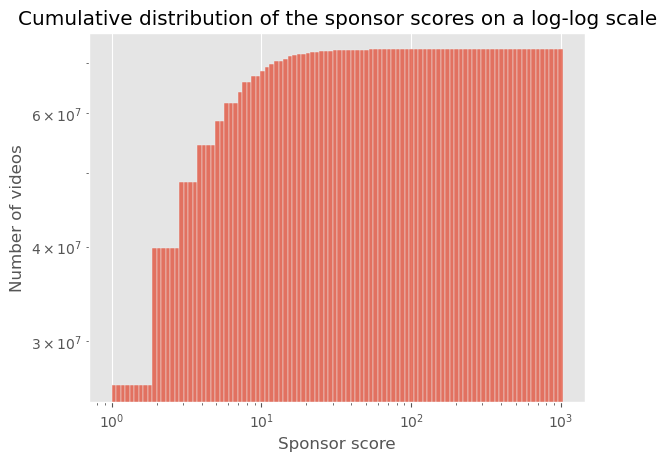

In [9]:
sns.histplot(shifted_scores, bins=100, log_scale=(True, True), cumulative=True)
plt.title("Cumulative distribution of the sponsor scores on a log-log scale")
plt.xlabel("Sponsor score")
plt.ylabel("Number of videos")
plt.show()

Note that the distribution is shifted by $1$ to have a satisfying range for the log-log plot. The great majority of videos have a sponsor score between $0$ and $10$, which seems to be a reasonable range. Many videos have a score of $0$ or $1$, which means that they might not be sponsored. A higher score might indicate that the video is sponsored, but too high of a score might be considered as an outlier.

Finally, we write the results to a parquet file.

In [13]:
PATH_METADATAS_SPONSOR_SCORES_DST = './data/generated/yt_metadata_en_sponsor_scores.parquet'

In [14]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_SPONSOR_SCORES_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_SPONSOR_SCORES_DST -Recurse -Force" # Windows

In [15]:
metadatas_sponsor_scores.write.parquet(PATH_METADATAS_SPONSOR_SCORES_DST, mode='overwrite')

## Analyse and Classify Domains

In this section, we will analyse and classify the domains retrieved from the processing steps.

We now have in our hands a list of domains for each video and a sponsor score determining whether the video description contains a sponsorship-related theme or not. We do the following:

1. First, we perform an overall analysis of the domains and find their average sponsor scores.

2. In a second step, we take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine whether they are sponsor-related or not. In this step, the average sponsor score might be a good indicator.

3. We perform an analysis on these popular domains.

### Broad Domain Analysis

From our previous domain and sponsor score analysis, we will merge them together to analyse the domains.

In [2]:
PATH_METADATAS_DOMAINS_SRC = './data/generated/yt_metadata_en_domains.parquet'
PATH_METADATAS_SPONSOR_SCORES_SRC = './data/generated/yt_metadata_en_sponsor_scores.parquet'

In [3]:
# Join the datasets together
metadatas_domains = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC)
metadatas_sponsor_scores = spark.read.parquet(PATH_METADATAS_SPONSOR_SCORES_SRC)
metadatas = metadatas_domains.join(metadatas_sponsor_scores, on='display_id', how='left')

In [ ]:
assert metadatas.count() == metadatas_domains.count()

In [4]:
# We have all the needed features for the domain analysis
metadatas.dtypes

[('display_id', 'string'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('domains', 'array<string>'),
 ('domains_count', 'int'),
 ('has_domains', 'string'),
 ('sponsor_score', 'int')]

In [4]:
metadatas.select('display_id', 'domains', 'sponsor_score').show(5)

+-----------+--------------------+-------------+
| display_id|             domains|sponsor_score|
+-----------+--------------------+-------------+
|82fVA65rbts|           [radi.al]|            2|
|Hpxh4XBQBEk|[whatcar.com, sma...|            9|
|K308-reAiTk|[linyibrickmachin...|            2|
|Qit2N489qqk|[whatcar.com, the...|            9|
|VFwTdmiqlmM|[iteachstamping.c...|            1|
+-----------+--------------------+-------------+
only showing top 5 rows



In [4]:
# Group every domain and count the number of videos that contain it.
domains_count = metadatas \
    .select(explode('domains').alias('domain')) \
    .groupBy('domain') \
    .count() \
    .orderBy('count', ascending=False)

In [5]:
total_counts = domains_count.select('count').collect()
total_counts = [c[0] for c in total_counts]

print(f"There are a total of {len(total_counts)} domains.")

There are a total of 1077304 domains.


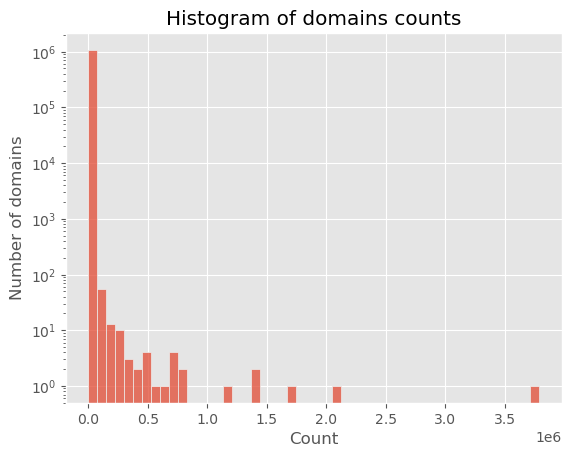

In [6]:
sns.histplot(total_counts, bins=50)
plt.yscale('log')
plt.title('Histogram of domains counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

There are about $1$ million distinct domains in the entire dataset. The distribution of the number of videos each domain occurs in is shown above. It seems to be **heavily right-skewed**, with a few domains occurring in a large number of videos.

### Domain Analysis on Popular Domains

Since there are so many domains, we will only focus on the most popular ones by filtering out the domains that occur in less than $10'000$ videos. Each video has a list of domains and a sponsor score, we can therefore infer a sponsor score for each popular domain by taking the median of the video sponsor scores containing the domain.

In [7]:
def find_median(values_list):
    try:
        median = np.median(values_list)
        return round(float(median), 2)
    except Exception:
        return None

In [8]:
MIN_DOMAIN_COUNT = 10_000

median_udf = udf(find_median, FloatType())

# Group every domain, count the number of videos that contain it and compute the median sponsor score.
domains_top_count = metadatas \
    .select(explode('domains').alias('domain'), 'sponsor_score') \
    .groupBy('domain') \
    .agg(count('domain').alias('count'), collect_list('sponsor_score').alias('sponsor_scores')) \
    .filter(f'count >= {MIN_DOMAIN_COUNT}') \
    .withColumn('median_sponsor_score', median_udf('sponsor_scores')) \
    .drop('sponsor_scores') \
    .orderBy('count', ascending=False)

In [9]:
domains_top_count.show(10)

+-------------------+-------+--------------------+
|             domain|  count|median_sponsor_score|
+-------------------+-------+--------------------+
|    plus.google.com|3786647|                 3.0|
|    play.google.com|2093786|                 4.0|
|   itunes.apple.com|1724603|                 3.0|
|             bit.ly|1408414|                 3.0|
|        tinyurl.com|1380122|                 4.0|
|          rstyle.me|1175073|                11.0|
| steamcommunity.com| 824573|                 3.0|
|creativecommons.org| 767740|                 4.0|
|        smarturl.it| 750397|                 3.0|
|              po.st| 739548|                 4.0|
+-------------------+-------+--------------------+
only showing top 10 rows



In [10]:
top_counts = domains_top_count.select('count').collect()
top_counts = [c[0] for c in top_counts]

print(f"There are a total of {len(top_counts)} domains with at least {MIN_DOMAIN_COUNT} counts.")

There are a total of 1000 domains with at least 10000 counts.


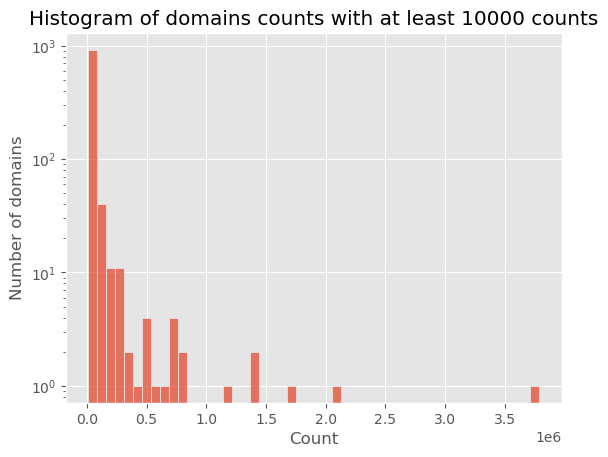

In [11]:
sns.histplot(top_counts, bins=50)
plt.yscale('log')
plt.title(f'Histogram of domains counts with at least {MIN_DOMAIN_COUNT} counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

Both distributions are **heavy-tailed to the right**. Indeed, there are many domains that appear in some videos only and a small subset of domains seem to prevail in many videos. This is a typical feature of a **power-law distributions**. The **log-log plot** of the distribution of the number of videos per domain is shown below.

Taking only domains that appear in at least $10'000$ videos does not change much the distribution as it might still be considered as a small amount of occurence for a domain. Nevertheless, we end up with only $1'000$ distinct domains to take into account, which is a reasonable amount of data to work with.

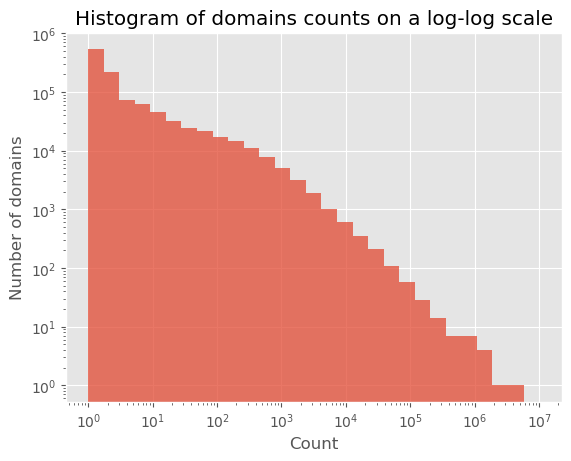

In [12]:
sns.histplot(total_counts, bins=np.logspace(0, 7, 30))
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of domains counts on a log-log scale')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

The distribution of the number of videos per domain follows approximately a straight line in the log-log plot above. It seems to approximately follow a **power-law distribution**.

Finally, we write the results to a csv file.

In [16]:
PATH_METADATAS_TOP_COUNTS_DST = '../data/generated/yt_metadata_en_domains_top_count.csv'

In [17]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_TOP_COUNTS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_TOP_COUNTS_DST -Recurse -Force" # Windows

In [18]:
domains_top_count.write.csv(PATH_METADATAS_TOP_COUNTS_DST)

### Classified Domains

We now take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine whether they are sponsor-related or not. In this step, the average sponsor score might help us to determine this. The classification labels that we came up with are the following:

|Class|Description|
|:--:|---|
|Agency|Agencies that aim to help YouTubers to develop, monetize their content|
|Application|Downloadable applications|
|Book|Book-related websites and shops|
|Beauty|Beauty-related websites and shops|
|Crypto|Cryptocurrency-related websites|
|Donation|Donation websites|
|Dating|Dating websites and applications|
|Education|Education-related websites|
|Entertainment|Entertainment-related websites|
|Fashion|Fashion-related websites and shops|
|Finance|Finance-related websites|
|Food Drink|Products related to food and drinks|
|Forum|Forum websites|
|Government|Government-related websites|
|Media|Takes into account news, newspapers, TV, radio, etc.|
|Medical|Medical-related websites|
|Music|Music-related websites and shops|
|OVP|Online Video Platform, users **can** upload on them|
|Photo|Photo-related websites and shops|
|Real Estate|Real estate-related websites|
|Religion|Religion-related websites|
|Science|Science-related websites|
|Service|Online services to help YouTubers such as video footages, music, stock footages, etc.|
|Sharing Service|Platform to share content such as Flickr, Imgur, etc.|
|Shop|Online shops that sell a high range of products (one that does not fall into either other categories)|
|Shorten|Shorten services (such as bit.ly, goo.gl, etc.)|
|Social Media|Social media websites|
|Sport|Sport-related websites and shops|
|Streaming|Online video platform, users **cannot** upload on them|
|Technology|Technology-related websites and shops|
|Travel|Travel-related websites and shops|
|Vehicle|Vehicle-related websites and shops|
|Video Game|Video game-related websites and shops|
|YCW|YouTube channel website: websites of channel videos|

In [13]:
# File containing the top classified domains
PATH_METADATAS_TOP_COUNTS_SRC = './data/domains_classification.csv'

In [14]:
schema = StructType([
    StructField("domain",               StringType(),  True),
    StructField("count",                IntegerType(), True),
    StructField("median_sponsor_score", FloatType(), True),
    StructField("is_sponsored",         IntegerType(), True),
    StructField("domain_category",      StringType(),  True),
])

domains_top_classified = spark.read.csv(PATH_METADATAS_TOP_COUNTS_SRC, header=True, schema=schema)
domains_top_classified = domains_top_classified.filter('domain_category is not null')

domains_top_classified = domains_top_classified \
    .withColumn("median_sponsor_score", domains_top_classified.median_sponsor_score.cast(IntegerType())) \
    .withColumn("is_sponsored", domains_top_classified.is_sponsored.cast(BooleanType()))

In [15]:
domains_top_classified.show()

+--------------------+-------+--------------------+------------+---------------+
|              domain|  count|median_sponsor_score|is_sponsored|domain_category|
+--------------------+-------+--------------------+------------+---------------+
|     plus.google.com|3786647|                   3|       false|   Social Media|
|     play.google.com|2093786|                   4|        true|    Application|
|    itunes.apple.com|1724603|                   3|       false|          Music|
|              bit.ly|1408414|                   3|       false|        Shorten|
|         tinyurl.com|1380122|                   4|       false|        Shorten|
|           rstyle.me|1175073|                  11|        true|         Agency|
|  steamcommunity.com| 824573|                   3|       false|     Video Game|
| creativecommons.org| 767740|                   4|       false|      Education|
|         smarturl.it| 750397|                   3|       false|        Shorten|
|               po.st| 73954

Below is a pie chart showing the distribution of the number of domains per class. We can see that there are about **a quarter of domains that were classified as sponsored-related**.

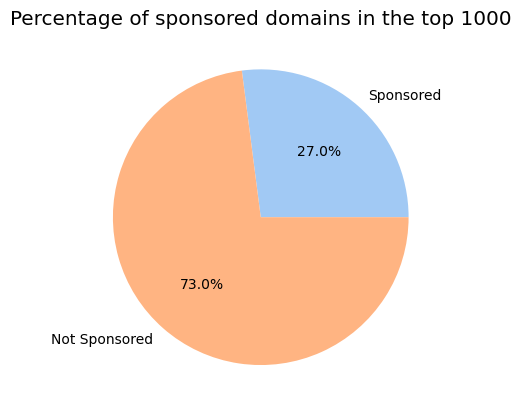

In [16]:
sp_domains_cnt = [row[1] for row in domains_top_classified.groupBy('is_sponsored').count().collect()]

colors = sns.color_palette('pastel')
plt.pie(sp_domains_cnt, labels=['Sponsored', 'Not Sponsored'], autopct='%1.1f%%', colors=colors)
plt.title('Percentage of sponsored domains in the top 1000')
plt.show()

In [17]:
sp_domains = domains_top_classified.filter(domains_top_classified.is_sponsored)
nsp_domains = domains_top_classified.filter(~domains_top_classified.is_sponsored)

In [22]:
sp_domains.show()

+------------------+-------+--------------------+------------+---------------+
|            domain|  count|median_sponsor_score|is_sponsored|domain_category|
+------------------+-------+--------------------+------------+---------------+
|   play.google.com|2093786|                   4|        true|    Application|
|         rstyle.me|1175073|                  11|        true|         Agency|
|             po.st| 739548|                   4|        true|         Agency|
|     teespring.com| 705812|                   4|        true|         Agency|
|       go.magik.ly| 691020|                  14|        true|         Agency|
|    streamlabs.com| 540814|                   4|        true|    Application|
|           geni.us| 527355|                   8|        true|         Agency|
|           g2a.com| 335453|                   6|        true|     Video Game|
|       studyiq.com| 306996|                  19|        true|      Education|
|          etsy.com| 296379|                   6|   

In [40]:
# Get the mean of the median sponsor score for sponsored and not sponsored domains
sp_domains_avg_score = sp_domains.select('median_sponsor_score').collect()
sp_domains_avg_score = [c[0] for c in sp_domains_avg_score]
sp_domains_avg_score = np.mean(sp_domains_avg_score)
sp_domains_avg_score

nsp_domains_avg_score = nsp_domains.select('median_sponsor_score').collect()
nsp_domains_avg_score = [c[0] for c in nsp_domains_avg_score]
nsp_domains_avg_score = np.mean(nsp_domains_avg_score)

print(f"The average median sponsor score for sponsored domains is {sp_domains_avg_score:.2f} and for not sponsored domains is {nsp_domains_avg_score:.2f}.")
print(f"The difference between the two is {sp_domains_avg_score - nsp_domains_avg_score:.2f}.")

The average median sponsor score for sponsored domains is 8.30 and for not sponsored domains is 3.92.
The difference between the two is 4.38.


As a sanity check, we can see that the mean sponsor score of the domains classified as sponsored-related is higher than the mean sponsor score of the domains classified as not sponsored-related. We indeed expect that the domains classified as sponsored-related have a higher sponsor score than the domains classified as not sponsored-related, and used this as a criterion to classify the domains.

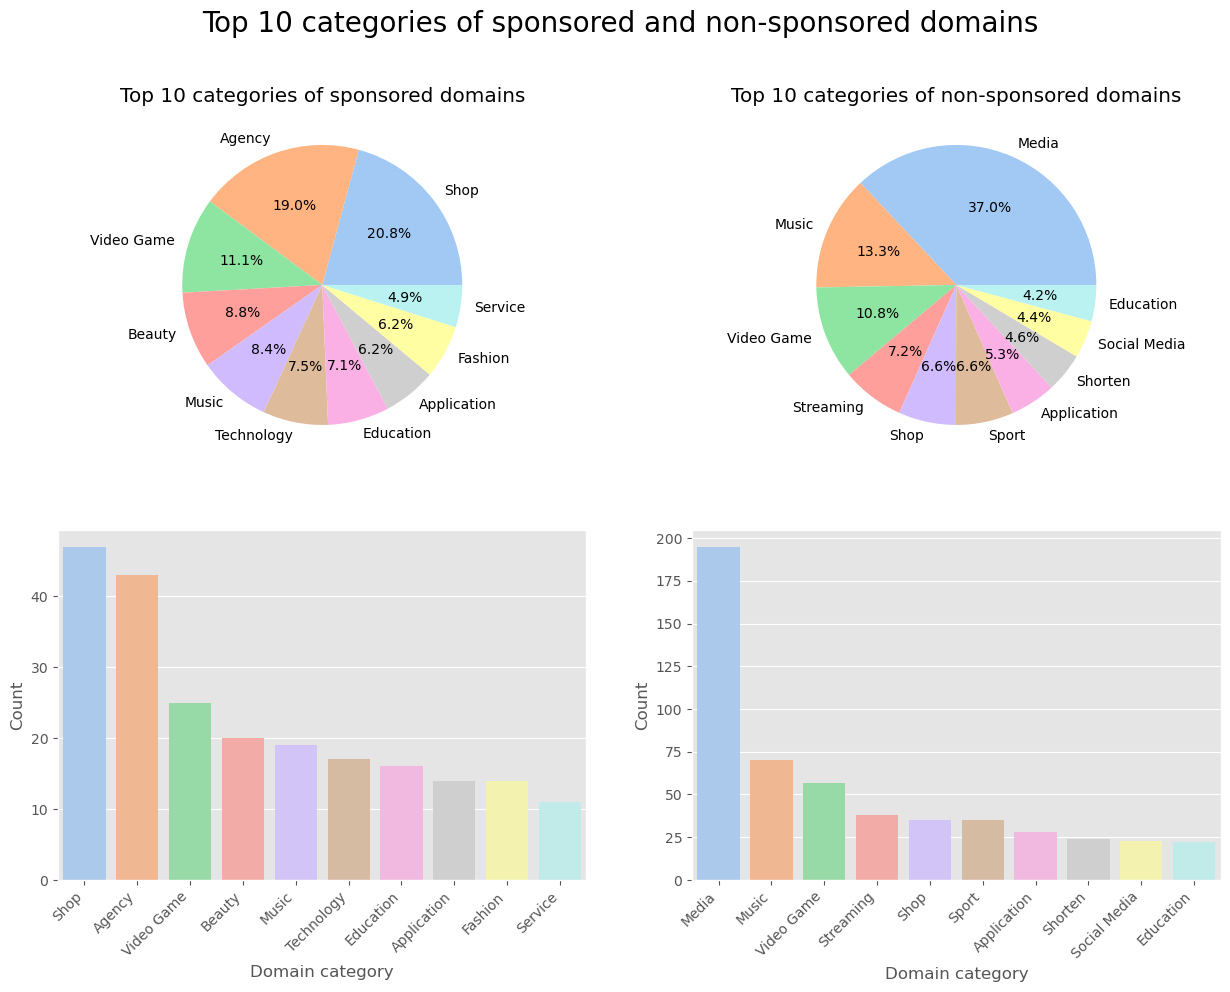

In [44]:
classified_sp_domains_cnt = [(row.domain_category, row[1]) for row in sp_domains.groupBy('domain_category').count().collect()]
classified_sp_domains_cnt = sorted(classified_sp_domains_cnt, key=lambda x: x[1], reverse=True)
classified_sp_domains_cnt = classified_sp_domains_cnt[:10]

classified_nsp_domains_cnt = [(row.domain_category, row[1]) for row in nsp_domains.groupBy('domain_category').count().collect()]
classified_nsp_domains_cnt = sorted(classified_nsp_domains_cnt, key=lambda x: x[1], reverse=True)
classified_nsp_domains_cnt = classified_nsp_domains_cnt[:10]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.pie(x=[x[1] for x in classified_sp_domains_cnt], labels=[x[0] for x in classified_sp_domains_cnt], autopct='%1.1f%%', colors=colors)
ax1.set_title('Top 10 categories of sponsored domains')

ax2.pie(x=[x[1] for x in classified_nsp_domains_cnt], labels=[x[0] for x in classified_nsp_domains_cnt], autopct='%1.1f%%', colors=colors)
ax2.set_title('Top 10 categories of non-sponsored domains')

sns.barplot(x=[x[0] for x in classified_sp_domains_cnt], y=[x[1] for x in classified_sp_domains_cnt], ax=ax3, palette=colors)
ax3.set(xlabel='Domain category', ylabel='Count')
plt.setp(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.barplot(x=[x[0] for x in classified_nsp_domains_cnt], y=[x[1] for x in classified_nsp_domains_cnt], ax=ax4, palette=colors)
ax4.set(xlabel='Domain category', ylabel='Count')
plt.setp(ax4.get_xticklabels(), rotation=45, horizontalalignment='right')

fig.suptitle('Top 10 categories of sponsored and non-sponsored domains', fontsize=20)
plt.show()

We can see that sponsored domains and non-sponsored domains are not equally distributed among the classes. Indeed, about a half of sponsored domains are related to **shops**, **agencies** and **video games**. On the other hand, **Media** and **Music** are the most popular classes for non-sponsored domains, where half of the domains are related to these classes.

These results make sense as many YouTubers are helped by agencies to develop their content and monetize it. They mainly sponsor products related to video games, beauty and shops.

Medias are the most popular class for non-sponsored domains. This may be due to the fact that YouTube is used by many medias, news and TV channels to share their content via their own YouTube channel without actually sponsoring it. Music is also a popular class for non-sponsored domains because YouTubers should always link to the original music they use in their videos.

### Analyse Agencies

In [6]:
PATH_METADATAS_TOP_COUNTS_SRC = "../data/domains_classification.csv"

In [35]:
domains_top_classified = pd.read_csv(PATH_METADATAS_TOP_COUNTS_SRC)
domains_top_classified.domain_category = domains_top_classified.domain_category.astype("category")
domains_top_classified.is_sponsored = domains_top_classified.is_sponsored.astype(bool)
# Get only agencies
domains_top_classified = domains_top_classified[domains_top_classified.domain_category == 'Agency']
# Take top 10 agencies
domains_top_classified = domains_top_classified.sort_values(by='count', ascending=False).head(10)

Text(0.5, 1.0, 'Top 10 Agencies')

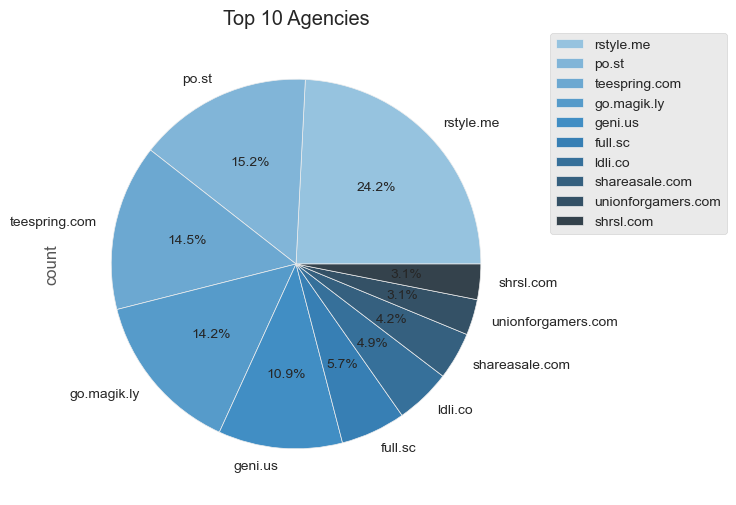

In [34]:
# pie chart of all agencies
colors = sns.color_palette("Blues_d", len(domains_top_classified.domain))
domains_top_classified.plot.pie(y='count', figsize=(6, 6), autopct='%1.1f%%', labels=domains_top_classified.domain, colors=colors)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Top 10 Agencies")

## Analyse Domains on Videos

In our previous analysis, we analyse domains without taking into account their occurence and popularity on YouTube. In this section, we deepen our analysis of the domains by taking into account the occurrence of the domains on YouTube. We proceed as follows:

1. We add weights to the domains based on the number of videos they appear in.

2. We perform a similar analysis as in the previous [section](#Analyse-and-Classify-Domains) with the weighted domains.

### Domain Analysis on Popular Weighted Domains

In [5]:
PATH_METADATAS_TOP_COUNTS_SRC = "../data/domains_classification.csv"

In [8]:
domains_top_classified = pd.read_csv(PATH_METADATAS_TOP_COUNTS_SRC)
domains_top_classified.domain_category = domains_top_classified.domain_category.astype("category")
domains_top_classified.is_sponsored = domains_top_classified.is_sponsored.astype(bool)

In [10]:
domains_top_classified.head(20)

,domain,count,median_sponsor_score,is_sponsored,domain_category
0,plus.google.com,3786647,3.0,False,Social Media
1,play.google.com,2093786,4.0,True,Application
2,itunes.apple.com,1724603,3.0,False,Music
3,bit.ly,1408414,3.0,False,Shorten
4,tinyurl.com,1380122,4.0,False,Shorten
5,rstyle.me,1175073,11.0,True,Agency
6,steamcommunity.com,824573,3.0,False,Video Game
7,creativecommons.org,767740,4.0,False,Education
8,smarturl.it,750397,3.0,False,Shorten
9,po.st,739548,4.0,True,Agency


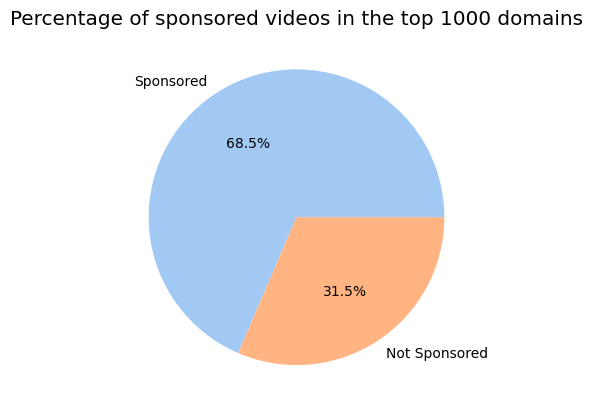

In [40]:
domains_count = domains_top_classified.groupby("is_sponsored")["count"].agg(["sum"]).values.reshape(-1,)

colors = sns.color_palette('pastel')
plt.title('Percentage of sponsored videos in the top 1000 domains')
plt.pie(domains_count, labels=["Sponsored", "Not Sponsored"], autopct="%1.1f%%", colors=colors)
plt.show()

We can see that, compared to [the domains analysis](#Analyse-and-Classify-Domains), the proportion of sponsored videos is the total inverse of the proportion of sponsoring domains ($27\%$ of sponsoring domains v.s. $68.5\%$ of sponsored videos). This is because sponsored domains tend to appear in many video as they are usually big companies trying to reach a large audience.

In [21]:
# Compute the percentage of links that sponsor videos or not in each category
sponsoring_ratio = domains_top_classified \
    .groupby(["domain_category", "is_sponsored"])["count"] \
    .sum() \
    .unstack() \
    .apply(lambda x: x / x.sum(), axis=1) \
    .sort_values(by=True, ascending=True)
sponsoring_ratio

is_sponsored,False,True
domain_category,,
Dating,1.000000,0.000000
Donation,1.000000,0.000000
Sharing Service,1.000000,0.000000
Science,1.000000,0.000000
OVP,1.000000,0.000000
OVM,1.000000,0.000000
Forum,1.000000,0.000000
Government,1.000000,0.000000
Movie,1.000000,0.000000


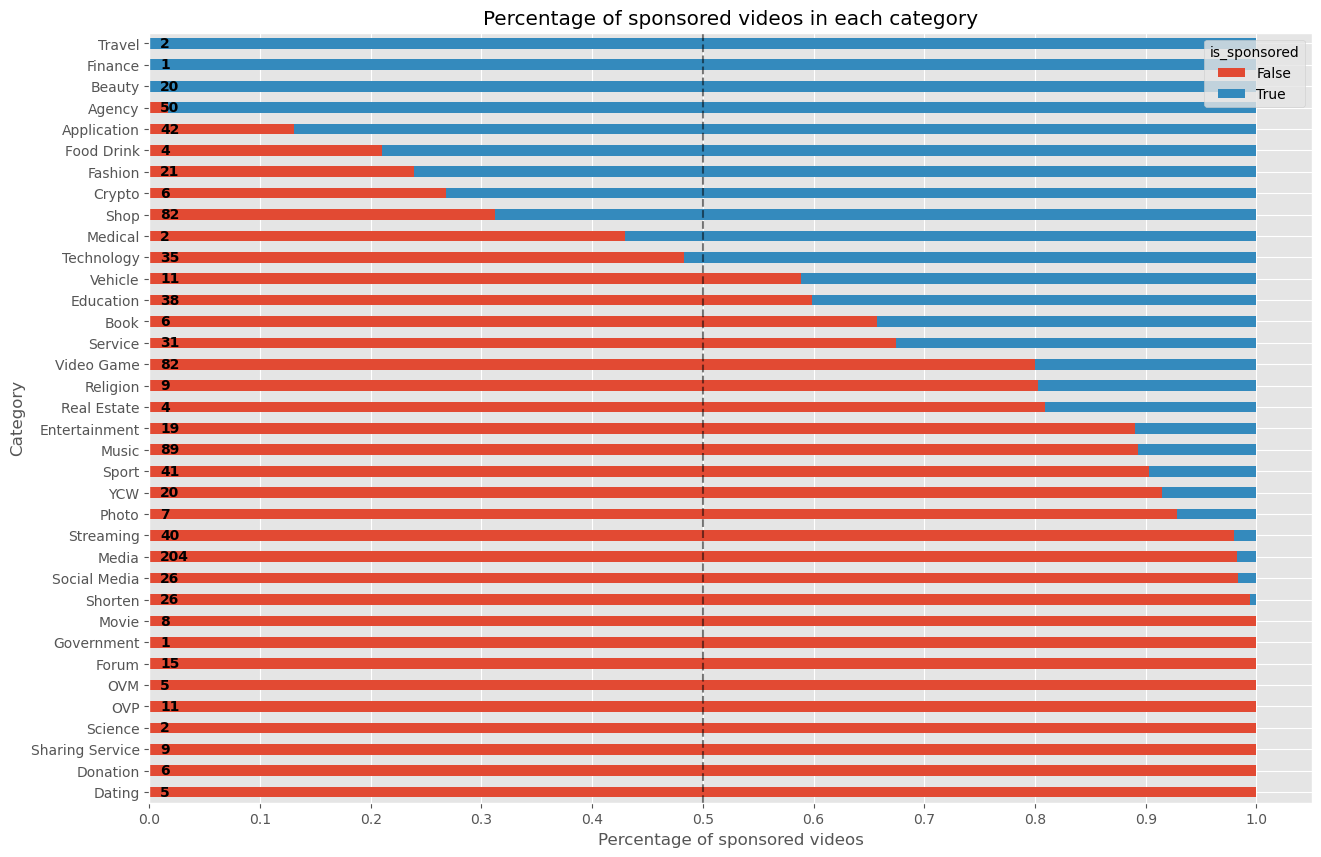

In [43]:
sponsoring_ratio.plot(kind="barh", stacked=True, figsize=(15, 10), title="Percentage of sponsored videos in each category")
plt.ylabel("Category")
plt.xlabel("Percentage of sponsored videos")
plt.axvline(x=0.5, color="black", linestyle="--", alpha=0.5)
plt.xticks(np.arange(0, 1.1, 0.1))
# show the number of entries for each category besides the name
for i, v in enumerate(sponsoring_ratio.index):
    plt.text(0.01, i, domains_top_classified[domains_top_classified.domain_category == v].count().values[0], color='black', va='center', fontweight='bold')
plt.show()

We can see that the `Travel`, `Finance` and `Beauty` categories are the ones that only appears as sponsor in videos. However, as we can see just above, the `Travel` and `Finance` categories are not relevant as they only account for 3 entries in the dataset. Note that the above graph takes into account the video count.

In [28]:
# Do the weighted average of the median_sponsor_score for each category
domains_top_classified["weighted_median_sponsor_score"] = domains_top_classified["median_sponsor_score"] * domains_top_classified["count"]
weighted_domains_top_classified = domains_top_classified.groupby("domain_category")[["weighted_median_sponsor_score", "count"]].sum()
weighted_domains_top_classified["weighted_median_sponsor_score"] = weighted_domains_top_classified["weighted_median_sponsor_score"] / weighted_domains_top_classified["count"]
weighted_domains_top_classified["weighted_median_sponsor_score"].sort_values(ascending=False).head(10)

domain_category
Beauty        14.817462
Travel        13.000000
Vehicle       12.323568
Food Drink     9.518328
Government     9.000000
Finance        9.000000
Religion       8.707868
Shop           8.358806
YCW            8.223012
Education      8.085043
Name: weighted_median_sponsor_score, dtype: float64

We can see that the `Beauty` category is the one that has the highest median sponsor score. This makes sense as beauty products are often advertised to be bought and as our sponsor vocaulary containes a lot of shopping related words (such as buy, get, free, purchase, etc.).

In [41]:
sp_domains = domains_top_classified[domains_top_classified.is_sponsored]
nsp_domains = domains_top_classified[~domains_top_classified.is_sponsored]

In [95]:
# Count the number of videos containing a link of a specific category
classified_sp_domains_cnt = sp_domains.groupby("domain_category")["count"].sum().sort_values(ascending=False)[:10]
classified_nsp_domains_cnt = nsp_domains.groupby("domain_category")["count"].sum().sort_values(ascending=False)[:10]

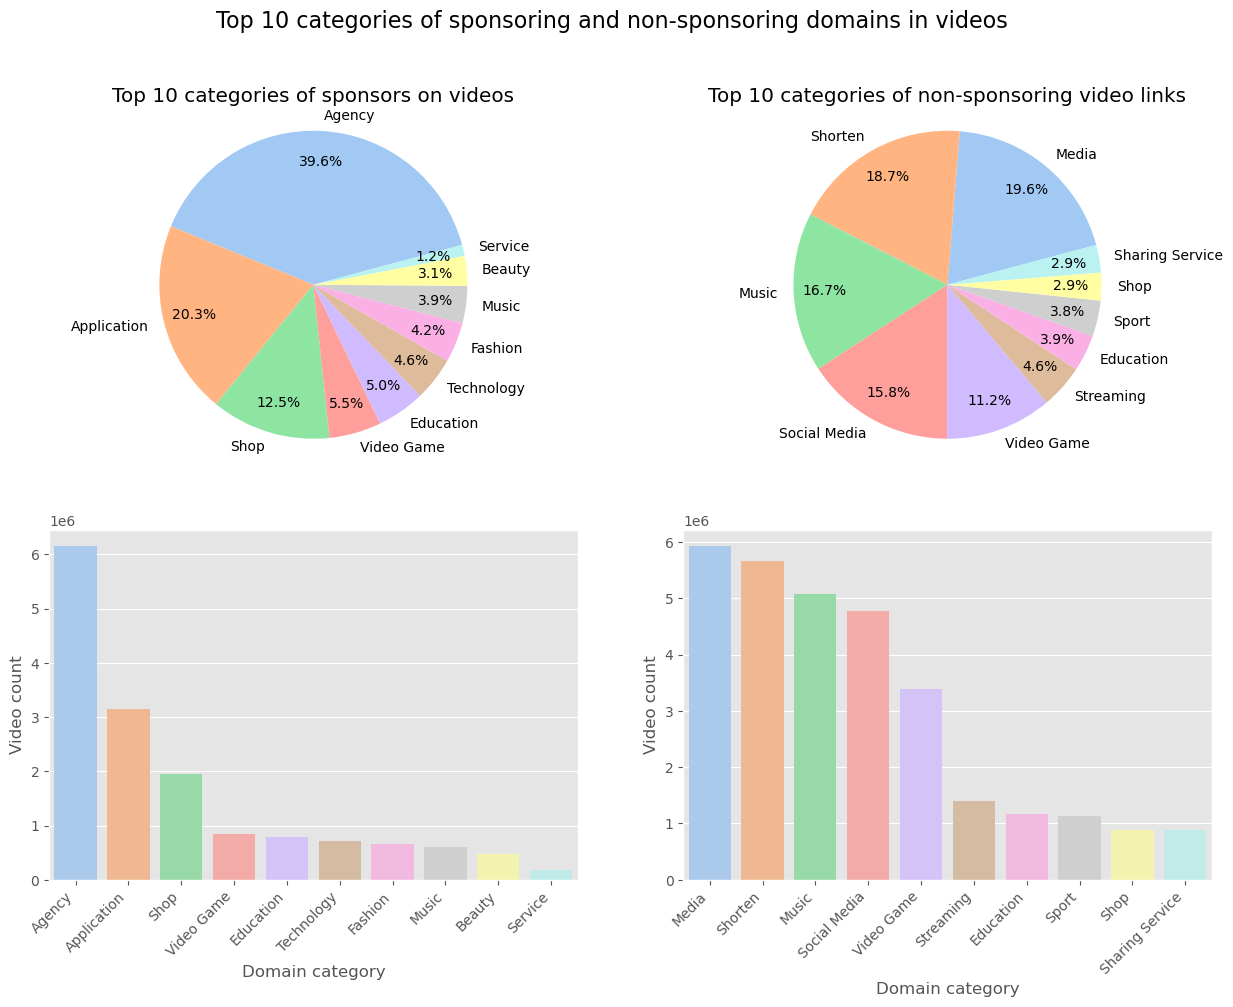

In [129]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle("Top 10 categories of sponsoring and non-sponsoring domains in videos", fontsize=16)

ax1.set_title("Top 10 categories of sponsors on videos")
ax1.pie(classified_sp_domains_cnt, labels=classified_sp_domains_cnt.index, autopct="%1.1f%%", colors=colors, radius=1.1, pctdistance=0.8, startangle=15)

ax2.set_title("Top 10 categories of non-sponsoring video links")
ax2.pie(classified_nsp_domains_cnt, labels=classified_nsp_domains_cnt.index, autopct="%1.1f%%", colors=colors, radius=1.1, pctdistance=0.8, startangle=15)

sns.barplot(x=classified_sp_domains_cnt.reset_index()["domain_category"].to_numpy(), y=classified_sp_domains_cnt, ax=ax3, palette=colors)
ax3.set(xlabel='Domain category', ylabel='Video count')
plt.setp(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.barplot(x=classified_nsp_domains_cnt.reset_index()["domain_category"].to_numpy(), y=classified_nsp_domains_cnt, ax=ax4, palette=colors)
ax4.set(xlabel='Domain category', ylabel='Video count')
plt.setp(ax4.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

Compared to the plots found in [the domains analysis](#Analyse-and-Classify-Domains), we can see that the `Agency` category of domains is the one that occurs in the most videos and by a significant amount. We can conclude that videos are generally sponsored by sponsoring agencies rather than direct products or services. This gives us a better understanding of the nature of sponsored videos.

We were baffeled by this discovery. Indeed, many of the potential sponsors that we thought of did not appear in this list (for example, one might think about [NordVPN](https://nordvpn.com/) or [Brilliant](https://brilliant.org/)). We would not have thought that videos were in general sponsored by sponsoring agencies.

## Network Analysis

In this section, we represent two specific networks to have a better understanding of the data. We use the [Gephi](https://gephi.org/) software to visualize the networks.

1. The first network is an undirected graph with nodes as videos ans sponsors, and edges appear between them if a video is sponsored by a sponsor.

2. The second network is an weighted undirected graph with nodes as sponsors, and edges appear between them if they sponsor videos together. The weights describe the number of videos they sponsor together, normalized.

In [1]:
import findspark
findspark.init()

import os
import glob
import pandas as pd
from itertools import combinations

from pyspark.sql.functions import udf, explode, collect_list, count
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution
spark = SparkSession(sc)

### Load the Data 

In [2]:
PATH_METADATAS_CLASSIFIED_DOMAINS_SRC = '../data/domains_classification.csv'
PATH_METADATAS_DOMAINS_SRC = '../data/generated/yt_metadata_en_domains.parquet'

In [3]:
schema_top_domains = ps.sql.types.StructType([
    StructField('domain', StringType(), True),
    StructField('count', IntegerType(), True),
    StructField('median_sponsor_score', FloatType(), True),
    StructField('is_sponsored', IntegerType(), True),
    StructField('domain_category', StringType(), True),
])

schema_domain_metadatas = StructType([
    StructField("categories",    StringType(),            True),
    StructField("channel_id",    StringType(),            True),
    StructField("dislike_count", DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),            True),
    StructField("duration",      IntegerType(),           True),
    StructField("like_count",    DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),            True),
    StructField("title",         StringType(),            True),
    StructField("upload_date",   DateType(),              True),
    StructField("view_count",    DoubleType(),            True),  # This field must be specified as a double as it is represented as a floating point number
    StructField("domains",       ArrayType(StringType()), True), 
    StructField("domains_count", IntegerType(),           True),
    StructField("has_domains",   BooleanType(),           True),
])

classified_domains = spark.read.csv(PATH_METADATAS_CLASSIFIED_DOMAINS_SRC, header=True, schema=schema_top_domains)
domain_metadatas = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC, schema=schema_domain_metadatas)

domain_metadatas = domain_metadatas \
    .withColumn("dislike_count", domain_metadatas.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", domain_metadatas.like_count.cast(IntegerType())) \
    .withColumn("view_count", domain_metadatas.view_count.cast(LongType()))

classified_domains = classified_domains \
    .withColumn("median_sponsor_score", classified_domains.is_sponsored.cast(IntegerType())) \
    .withColumn("is_sponsored", classified_domains.is_sponsored.cast(BooleanType()))

### Generate the Video-Sponsor Network

In [4]:
# Retrieve the sponsored domains
sp_domains = classified_domains.select('domain').where(classified_domains.is_sponsored).collect()
sp_domains = [domain.domain for domain in sp_domains]

In [5]:
# Retrieve the sponsored domains with their category
sp_domains_cat = classified_domains.select('domain', 'domain_category').where(classified_domains.is_sponsored).collect()
sp_domains_cat = [(domain.domain, domain.domain_category) for domain in sp_domains_cat]
# Create a dictionary with the sponsored domains as keys and their category as values
sp_domains_cat = dict(sp_domains_cat)

In [6]:
domain_metadatas.show(10)

+----------------+--------------------+-------------+-----------+--------+----------+--------------------+--------------------+-----------+----------+--------------------+-------------+-----------+
|      categories|          channel_id|dislike_count| display_id|duration|like_count|                tags|               title|upload_date|view_count|             domains|domains_count|has_domains|
+----------------+--------------------+-------------+-----------+--------+----------+--------------------+--------------------+-----------+----------+--------------------+-------------+-----------+
|                |UCD8GawxPXpJnql46...|         null|Gt_r6SrOxv8|    6183|      null|                    |Los Angeles to Sa...| 2019-09-28|     13695|  [tipeeestream.com]|            1|       true|
|Autos & Vehicles|UC-9IhqrFTkc53Dx1...|            6|xNoMrPUlBzw|     230|       134|new cars,new york...|First Look at the...| 2019-04-22|      2194|[creativecommons....|            1|       true|
|Autos & V

In [6]:
def is_in_top_domains(domain):
    return domain in sp_domains

In [7]:
# Explode the domains and keep only the rows with a sponsored domain
is_in_top_domains_udf = udf(is_in_top_domains, BooleanType())
domain_metadatas_vs = domain_metadatas \
    .withColumn('domain', explode(domain_metadatas.domains).alias('domain'))
domain_metadatas_vs = domain_metadatas_vs.select('display_id', 'domain') \
    .withColumn('is_in_top_domains', is_in_top_domains_udf(domain_metadatas_vs.domain))
domain_metadatas_vs = domain_metadatas_vs \
    .where(domain_metadatas_vs.is_in_top_domains) \
    .drop('is_in_top_domains') \
    .distinct()

In [9]:
domain_metadatas_vs.show(10)

+-----------+---------------+
| display_id|         domain|
+-----------+---------------+
|CcJtdkaf0Hk|     newegg.com|
|Hgzonw__mUI|play.google.com|
|3ZMPz2K5uJ8|play.google.com|
|gjg66FPuXME|     zazzle.com|
|6bQ17PH-iWk|play.google.com|
|z9Mqj9EXaBg|   spreaker.com|
|ZQ7OiOISmMU|   spreaker.com|
|I7ODh021stA|     artlist.io|
|zSLPIRY9srU|   testbook.com|
|b7T7ej5G84w|play.google.com|
+-----------+---------------+
only showing top 10 rows



In [8]:
# Add the domain category
def get_domain_category(domain):
    if domain in sp_domains_cat:
        return sp_domains_cat[domain]
    return None 

get_domain_category_udf = udf(get_domain_category, StringType())
domain_metadatas_vs = domain_metadatas_vs \
    .withColumn('domain_category', get_domain_category_udf(domain_metadatas_vs.domain))

In [11]:
domain_metadatas_vs.show(10)

+-----------+---------------+---------------+
| display_id|         domain|domain_category|
+-----------+---------------+---------------+
|CcJtdkaf0Hk|     newegg.com|     Technology|
|Hgzonw__mUI|play.google.com|    Application|
|3ZMPz2K5uJ8|play.google.com|    Application|
|gjg66FPuXME|     zazzle.com|           Shop|
|6bQ17PH-iWk|play.google.com|    Application|
|z9Mqj9EXaBg|   spreaker.com|         Agency|
|ZQ7OiOISmMU|   spreaker.com|         Agency|
|I7ODh021stA|     artlist.io|          Music|
|zSLPIRY9srU|   testbook.com|      Education|
|b7T7ej5G84w|play.google.com|    Application|
+-----------+---------------+---------------+
only showing top 10 rows



This final dataframe describes the edges of the network, from the video described as its `display_id` to the sponsor described as its `domain`. The `domain_category` is the category of the sponsor. We only take a sample of the data to avoid memory issues, while still having a good representation of the data.

In [9]:
SAMPLE_RATIO = 0.01
SAMPLE_SEED = 0
domain_metadatas_vs = domain_metadatas_vs.sample(False, SAMPLE_RATIO, seed=SAMPLE_SEED)

In [10]:
domain_metadatas_vs.write.csv('../data/generated/yt_network.csv', mode='overwrite')

In [11]:
NETWORK_PATH = "../data/generated/yt_network.csv/"

all_files = glob.glob(os.path.join(NETWORK_PATH, "part-*.csv"))
df_from_each_file = [pd.read_csv(f, sep=',', header=None) for f in all_files]
df_merged = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv(NETWORK_PATH + "merged.csv")

### Generate the Sponsor-Sponsor Network

In [14]:
# Get all distinct pairs of domains from the same video
combinations_udf = udf(lambda x: list(combinations(list(set(x)), 2)), "array<struct<domain1:string,domain2:string>>")

In [15]:
# Explode the domains and keep only the rows with a sponsored domain
is_in_top_domains_udf = udf(is_in_top_domains, BooleanType())
domain_metadatas_ss = domain_metadatas \
    .withColumn('domain', explode(domain_metadatas.domains).alias('domain'))
domain_metadatas_ss = domain_metadatas_ss.select('display_id', 'domain') \
    .withColumn('is_in_top_domains', is_in_top_domains_udf(domain_metadatas_ss.domain))
domain_metadatas_ss = domain_metadatas_ss \
    .where(domain_metadatas_ss.is_in_top_domains) \
    .drop('is_in_top_domains') \
    .distinct()

In [16]:
# List them back together
domain_metadatas_ss = domain_metadatas_ss \
    .groupBy('display_id') \
    .agg(collect_list('domain').alias('domains'))

In [16]:
domain_metadatas_ss.select('display_id', 'domains').show(10, False)

+-----------+-----------------------------------------------------------------------+
|display_id |domains                                                                |
+-----------+-----------------------------------------------------------------------+
|---jqfcks4Y|[gamewisp.com]                                                         |
|---rKGl6b6k|[play.google.com]                                                      |
|--1-YLWkQgc|[e.lga.to]                                                             |
|--1udHoGWFY|[fr.shopping.rakuten.com, sigma-beauty.7eer.net, rstyle.me, ebates.com]|
|--2qGzZS0cc|[wattpad.com]                                                          |
|--322IagBXo|[epidemicsound.com)]                                                   |
|--3gtM7gnCQ|[fiverr.com]                                                           |
|--4TsCinz9Y|[teespring.com, streamlabs.com]                                        |
|--4qhrXSuTs|[sellfy.com]                             

In [17]:
domain_metadatas_ss = domain_metadatas_ss.withColumn('domains', explode(combinations_udf(domain_metadatas_ss.domains)).alias('domains'))

In [14]:
domain_metadatas_ss.select('display_id', 'domains').show(10, False)

+-----------+------------------------------------------------+
|display_id |domains                                         |
+-----------+------------------------------------------------+
|--1udHoGWFY|{fr.shopping.rakuten.com, rstyle.me}            |
|--1udHoGWFY|{fr.shopping.rakuten.com, sigma-beauty.7eer.net}|
|--1udHoGWFY|{fr.shopping.rakuten.com, ebates.com}           |
|--1udHoGWFY|{rstyle.me, sigma-beauty.7eer.net}              |
|--1udHoGWFY|{rstyle.me, ebates.com}                         |
|--1udHoGWFY|{sigma-beauty.7eer.net, ebates.com}             |
|--4TsCinz9Y|{streamlabs.com, teespring.com}                 |
|--AT5_SIBBg|{hautelook.com, sigmabeauty.com}                |
|--AeWbCVaNA|{etsy.com, ebates.com}                          |
|--E5fYurbTk|{teespring.com, play.google.com}                |
+-----------+------------------------------------------------+
only showing top 10 rows



In [18]:
# Get the 2 domains in separate columns
domain_metadatas_ss = domain_metadatas_ss \
    .withColumn('domain1', domain_metadatas_ss.domains.domain1) \
    .withColumn('domain2', domain_metadatas_ss.domains.domain2) \
    .drop('domains') \
    .select('domain1', 'domain2')

# Get weights
domain_metadatas_ss = domain_metadatas_ss \
    .groupBy('domain1', 'domain2') \
    .agg(count('domain1').alias('weight'))

# Normalize the weights
max_weight = domain_metadatas_ss.agg({'weight': 'max'}).collect()[0][0]
domain_metadatas_ss = domain_metadatas_ss \
    .withColumn('weight', domain_metadatas_ss.weight / max_weight)

In [19]:
domain_metadatas_ss.show(10)

+------------------+--------------------+--------------------+
|           domain1|             domain2|              weight|
+------------------+--------------------+--------------------+
|        airbnb.com|      shareasale.com|0.003622562610790...|
|     tubebuddy.com|     erincondren.com|0.001918094632062179|
|           seph.me|            ulta.com|0.004986136993773...|
|noscopeglasses.com|          cdkeys.com|0.002249897731921...|
|      coinbase.com|          medium.com|0.004049815917458298|
|         rstyle.me|fr.shopping.rakut...|0.013667560565428845|
|     teespring.com|         audible.com| 0.00974955683832553|
|        ebates.com|    m.freemyapps.com|3.363483478023726E-4|
|     tubebuddy.com|             bstk.me|0.002268078723694...|
|    rover.ebay.com|            bhpho.to|0.001290850415890...|
+------------------+--------------------+--------------------+
only showing top 10 rows



The final dataframe describes the edges of the network, from a sponsor `domain1` to another sponsor `domain2`. The `weight` is the number of videos they sponsor together, normalized.

In [20]:
domain_metadatas_ss.write.csv('../data/generated/yt_network_ss.csv', mode='overwrite')

In [21]:
NETWORK_PATH = "../data/generated/yt_network_ss.csv/"

all_files = glob.glob(os.path.join(NETWORK_PATH, "part-*.csv"))
df_from_each_file = [pd.read_csv(f, sep=',', header=None) for f in all_files]
df_merged = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv(NETWORK_PATH + "merged.csv")

### Visualize the Networks

The first network has nodes representing both the videos and the domains. Every video has an edge to every sponsored domain it contains in its description. Using Yifan Hu's algorithm to layout the graph, we get the following visualization:

<img title="network_01_visualization" alt="Network 01 visualization" width="800" src="./generated/network/vs/01.png">
<img title="network_01_legend" alt="Network 01 legend" width="100" src="./generated/network/vs/legend.png">

This network shows us that the **videos rarely have more than one sponsor** in their description. Indeed, the vast majority of the sponsor nodes are pushed outwards since they only have their own video community. Also note that we took a sample of $\frac{1}{100}\text{th}$ of the full dataset. Taking only a subset of the data might be discriminatory towards the videos with many sponsors, since they are rarely present in the full dataset.

We still have some interesting findings comming out of this graph. Indeed, it seems that `play.google.com` and `apps.apple.com` share a non-negligible number of videos. This is probably due to the fact that they are both app stores, and videos link them together since many applications are available for both Android and iOS.

Also, clusters in the middle tend to be related to the same domain. For example, `sephora.com`, `ipsy.com` and some other cosmetic websites are close to each other. This is probably due to the fact that some beauty-related videos are sponsored by many of these types of websites. Here is a close-up of the specific cluster:

<img title="network_01_visualization" alt="Network 01 visualization" width="500" src="./generated/network/vs/02.png">

We now take a look at a second network. This time, we only have nodes representing the domains, and edges exists between two domains if they sponsor videos together. Using Force Atlas to layout the graph, we get the following visualization:

<img title="network_02_visualization" alt="Network 02 visualization" width="800" src="./generated/network/ss/01.png">
<img title="network_02_legend" alt="Network 02 legend" width="100" src="./generated/network/ss/legend.png">

We now do not take into account videos that only have one sponsor in their description, since no edge would be created. The graph is now much more dense, and clusters are more visible. We can still see that **`play.google.com` and `apps.apple.com` are very related to each other**, since they are close to each other. Also, being in the center of the graph is a good indicator that **these domains sponsor many diverse videos**! Here is a close-up of the region of interest:

<img title="network_02_visualization" alt="Network 02 visualization" width="500" src="./generated/network/ss/02.png">

The agencies seem to appear everywhere in the graph and there are a good number of them in the center. This tells us that **agencies are omnipresent** in the data, sponsoring and **targetting a broad range of videos**.

Interestingly enough, **there seems to be two main clusters**: a big one in the top left, and a smaller one in the bottom right. The bigger cluster groups together many sponsors related to **video games, technology and applications**. The smaller cluster is more related to **beauty and fashion**. This gives us reasonable insights about the data: fashion-related and tech-related videos tend to form different communities on YouTube, which can directly be seen with the relation between sponsors! Here is a close-up of the specific clusters:

<img title="network_02_visualization" alt="Network 02 visualization" width="500" src="./generated/network/ss/04.png">
<img title="network_02_visualization" alt="Network 02 visualization" width="350" src="./generated/network/ss/03.png">

Finally, **shops** are noticeably placed in the outer part of the graph. This could tell us that they might tend to target a broader audience, and not only a specific community. Having low weights between many different nodes could lead to such a configuration. Such examples are `aliexpress.com` or `bangood.com`, which are both e-commerce websites. Both of them sell a wide range of products, from electronics to fashion.

Here is a graph showing the clustering coefficient distribution of the nodes:

<img title="network_02_cluster_coeff" alt="Network 02 clustering coefficient" width="600" src="./generated/network/ss/clustering-coefficient.png">

Here is a graph of the closeness centrality distribution of the nodes:

<img title="network_02_cluster_coeff" alt="Network 02 clustering coefficient" width="600" src="./generated/network/ss/closeness.png">

The mean clustering coefficient is $\approx 0.65$. This means that **communities of sponsors are quite common** when taking into account only the interraction between them. Indeed for example, the domain `sephora.com` is often found alongside `ipsy.com` but also `ulta.com`, which together form a community of cosmetic-related sponsors.

The closeness centrality distribution also shows us that **the graph is well connected**. Indeed, the mean closeness centrality is $\approx 0.6$. Besides some outliers, this metric is quite high, which means that sponsors are often found in communities.

Since many shops and agencies tend to target vast audiences, they also may be the nodes connecting some more specific communities. This could explain why we see that the closeness centrality of the agencies is quite high.

## Add Features to the Metadata Dataset

In this section, we add new features together to continue our analysis. We have the following features:
* `diff_month`: the number of elapsed months from the creation of the first video.
* `domains`: the domains of the video.
* `domain_categories`: the categories of the sponsored domains of the video.
* `is_sponsored`: whether the video is sponsored or not (i.e. contains sponsored domains).

### Add Sponsored Domains to Videos

In [2]:
PATH_METADATAS_DOMAINS_SRC = 'data/generated/yt_metadata_en_domains.parquet'
PATH_DOMAIN_CLASSIFICATION = "data/domains_classification.csv"

In [3]:
metadatas_domains = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC)

# Get a dict of sponsored domains with their category
domain_class = pd.read_csv(PATH_DOMAIN_CLASSIFICATION)
domain_class = domain_class[domain_class.is_sponsored == 1].set_index('domain')['domain_category'].to_dict()

In [4]:
metadatas_domains.select('display_id', 'domains').show(10, False)

+-----------+----------------------------------------------------------------------------------------------------------+
|display_id |domains                                                                                                   |
+-----------+----------------------------------------------------------------------------------------------------------+
|Gt_r6SrOxv8|[tipeeestream.com]                                                                                        |
|xNoMrPUlBzw|[creativecommons.org]                                                                                     |
|HBtx33c7WDE|[ebay.com, fxo.co, cafepress.com, ebay.com, tinyurl.com, ebay.com, ebay.com, ebay.com, ebay.com, ebay.com]|
|r5JH6DDTpV8|[ebay.com, fxo.co, cafepress.com, ebay.com, ebay.com, ebay.com, ebay.com, tinyurl.com]                    |
|0ZoegwnAF_w|[whatcar.com, whatcar.com, whatcar.com]                                                                   |
|d2mfhzj1aOI|[whatcar.com, whatc

In [5]:
def domain_is_sponsor(domain):
    return domain in domain_class

def get_domain_category(domain):
    if domain in domain_class:
        return domain_class[domain]
    else:
        return None

domain_is_sponsor_udf = udf(domain_is_sponsor, BooleanType())
get_domain_category_udf = udf(get_domain_category, StringType())

# We first explode de domains and add the missing information about sponsorships for each domain in each video
metadatas_domains = metadatas_domains.withColumn("domain", explode("domains")) \
    .drop("domains")
metadatas_domains = metadatas_domains.withColumn("is_sponsored", domain_is_sponsor_udf("domain")) \
    .withColumn('domain_category', get_domain_category_udf("domain")) \

# We regroup the information back together to have a list of distinct sponsored domains
# and a sponsor flag for each video if at least one of the domains is sponsored
metadatas_domains = metadatas_domains.groupby("display_id") \
    .agg(
        collect_list("domain").alias("domains"),
        collect_list("domain_category").alias("domain_categories"),
        collect_list("is_sponsored").alias("is_sponsoreds")
    ) \
    .withColumn("is_sponsored", udf(lambda x: any(x), BooleanType())("is_sponsoreds")) \
    .withColumn("domain_categories", udf(lambda x: list(set(x)), StringType())("domain_categories")) \
    .drop("domain", "domain_category", "is_sponsoreds")

In [11]:
metadatas_domains.select('display_id', 'domains', 'is_sponsored', 'domain_categories').filter(metadatas_domains.is_sponsored).show(10)

+-----------+--------------------+------------+--------------------+
| display_id|             domains|is_sponsored|   domain_categories|
+-----------+--------------------+------------+--------------------+
|---jqfcks4Y|      [gamewisp.com]|        true|            [Agency]|
|--1udHoGWFY|[rstyle.me, rstyl...|        true|[Agency, Beauty, ...|
|--6bIzrgY3I|[play.google.com,...|        true|       [Application]|
|--7kvpZtKDE|    [streamlabs.com]|        true|       [Application]|
|--8bLO31olY|[google.com, even...|        true|            [Agency]|
|--BJEQK3lZ8| [doubtnut.app.link]|        true|       [Application]|
|--Bu6_czcUw|[play.google.com,...|        true|       [Application]|
|--D9SNFXu4k|[apps.apple.com, ...|        true|       [Application]|
|--F-0qN4gXU|[psnprofiles.com,...|        true|              [Shop]|
|--HsbU1M3rY|[play.google.com,...|        true|       [Application]|
+-----------+--------------------+------------+--------------------+
only showing top 10 rows



In [12]:
metadatas_domains.select('display_id', 'domains', 'is_sponsored', 'domain_categories').filter(~metadatas_domains.is_sponsored).show(10)

+-----------+--------------------+------------+-----------------+
| display_id|             domains|is_sponsored|domain_categories|
+-----------+--------------------+------------+-----------------+
|---1Yr75DDo|[pond5.com, foota...|       false|               []|
|---SLoSKUoc|[plus.google.com,...|       false|               []|
|---y_F0JOYY|[worldbossteam.co...|       false|               []|
|--1mZyOoA9o|[TheMelaninCode.c...|       false|               []|
|--1wdNZnvY8|[roblox.com, robl...|       false|               []|
|--2aaCq_Rg8|[store.playstatio...|       false|               []|
|--2lK1tBnY4|         [newsx.com]|       false|               []|
|--2nX2IK1fY|      [musicfog.com]|       false|               []|
|--34oO-c1zA|[wecrafter.com, w...|       false|               []|
|--3XHHGVZTg|[bhaarattoday.com...|       false|               []|
+-----------+--------------------+------------+-----------------+
only showing top 10 rows



### Add Months to Videos

In [6]:
def diff_month(d1,d2):
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month

diff_month_udf = udf(lambda d1,d2: diff_month(d1,d2), IntegerType())
start_date = metadatas_domains.select('upload_date').agg({'upload_date': 'min'}).collect()[0][0]
metadatas_domains = metadatas_domains.withColumn('diff_month', diff_month_udf('upload_date', lit(start_date)))

In [7]:
metadatas_domains.show(10)

+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
| display_id|             domains|domain_categories|is_sponsored|      categories|          channel_id|crawl_date|         description|dislike_count|duration|like_count|                tags|               title|upload_date|view_count|diff_month|
+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
|---1Yr75DDo|[pond5.com, foota...|               []|       false|Film & Animation|UCarI394EclOjlRrm...|2019-11-18|http://www.pond5....|            2|      47|        11|free Chroma Key E...|Explosion 1 - gre...| 2012-07-14|      3708|        84|
|---SLoSKUoc|[pl

In [9]:
PATH_ALL_METADATAS_SRC = '../data/generated/all_metadatas_en.parquet'

metadatas_domains.write.parquet(PATH_ALL_METADATAS_SRC)

## Analyse the Effect of Sponsors on Videos

In this section, we explore the effect on sponsors on videos, following these steps:

1. First, we apply a **bootstrap analysis** on the features of sponsored and non-sponsored videos.

2. Then, we run some **t-tests** to see if there are significant differences between sponsored and non-sponsored videos.

3. Finally, we perform a **matching analysis** to reduce the bias of our observational study, matching sponsored and non-sponsored videos on the features that we found to be significant for videos.

In [1]:
# FINDSPARK
import findspark
findspark.init()

# BASIC IMPORTS
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_rel

import statsmodels.api as sm
import statsmodels.formula.api as smf

import networkit as nk

# PYSPARK
from pyspark.sql.functions import col, udf, explode, when, collect_list, size, mean
from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow when repartitioning.
config.set('spark.driver.maxResultSize', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

plt.style.use('ggplot')

### Analysis of Sponsored Categories 

In [10]:
PATH_ALL_METADATAS_SRC = '../data/generated/all_metadatas_en.parquet'

In [11]:
all_metadatas = spark.read.parquet(PATH_ALL_METADATAS_SRC)

In [12]:
all_metadatas.dtypes

[('display_id', 'string'),
 ('domains', 'array<string>'),
 ('domain_categories', 'array<string>'),
 ('is_sponsored', 'boolean'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('crawl_date', 'date'),
 ('description', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('diff_month', 'int')]

In [13]:
all_metadatas.show(10)

+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
| display_id|             domains|domain_categories|is_sponsored|      categories|          channel_id|crawl_date|         description|dislike_count|duration|like_count|                tags|               title|upload_date|view_count|diff_month|
+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
|---1Yr75DDo|[pond5.com, foota...|               []|       false|Film & Animation|UCarI394EclOjlRrm...|2019-11-18|http://www.pond5....|            2|      47|        11|free Chroma Key E...|Explosion 1 - gre...| 2012-07-14|      3708|        84|
|---SLoSKUoc|[pl

In [14]:
domain_categories_count = all_metadatas \
    .withColumn('domain_categories_count', size('domain_categories')) \
    .groupBy('domain_categories_count') \
    .count().orderBy('domain_categories_count', ascending=True) \
    .toPandas()

In [15]:
domain_categories_count['domain_categories_count'] += 0.001

In [16]:
domain_categories_count.head()

,domain_categories_count,count
0,0.001,28193007
1,1.001,6369092
2,2.001,838282
3,3.001,134564
4,4.001,23123


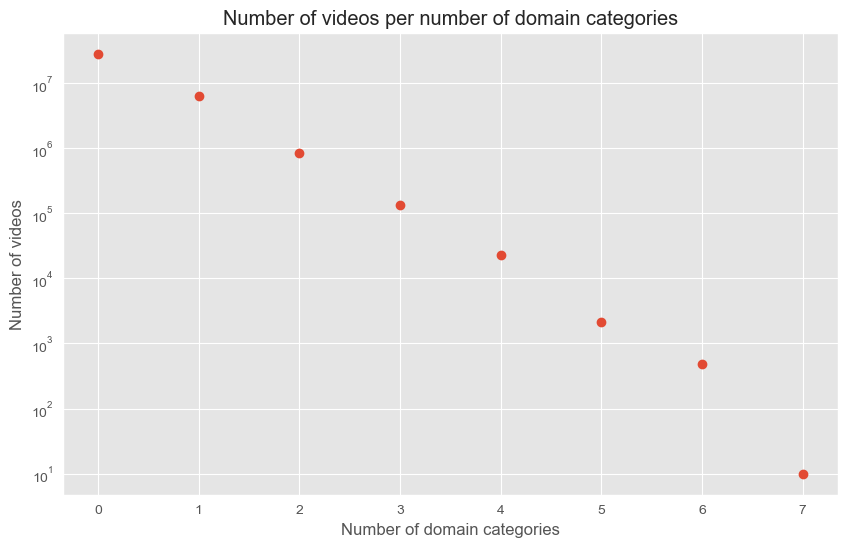

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(domain_categories_count['domain_categories_count'], domain_categories_count['count'], 'o')
plt.yscale('log')
plt.xlabel('Number of domain categories')
plt.ylabel('Number of videos')
plt.title('Number of videos per number of domain categories')
plt.show()

The **majority of videos are not classified as being sponsored by our model**, having no sponsored domains. A a vast majority of sponsored videos **tend to have only one sponsor**. This analysis has also been supported by the network analysis since sponsor nodes were mostly isolated.

In [18]:
video_categories = all_metadatas \
    .where(col('is_sponsored')) \
    .where(col('categories') != '') \
    .withColumn('domain_category', explode('domain_categories')) \
    .groupby('categories', 'domain_category') \
    .count() \
    .orderBy('count', ascending=False) \
    .toPandas()

In [19]:
video_categories = video_categories.set_index('categories') \
    .pivot(columns='domain_category', values='count')

video_categories_count = video_categories \
    .sum(axis=1) \
    .sort_values(ascending=True) \
    .to_frame() \

video_categories_top = video_categories.apply(lambda x: x.sort_values(ascending=False).head(3), axis=1) \
    .reindex(video_categories.sum(axis=1).sort_values(ascending=True).index)

In [20]:
video_categories_top.head()

domain_category,Agency,Application,Beauty,Education,Media,Music,Service,Shop,Travel,Vehicle,Video Game
categories,,,,,,,,,,,
Nonprofits & Activism,2544.0,4484.0,NaN,1033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pets & Animals,13033.0,4340.0,NaN,NaN,NaN,NaN,4897.0,NaN,NaN,NaN,NaN
Travel & Events,13958.0,6739.0,NaN,NaN,NaN,NaN,NaN,NaN,9444.0,NaN,NaN
Comedy,23606.0,13762.0,NaN,NaN,NaN,NaN,NaN,9482.0,NaN,NaN,NaN
Autos & Vehicles,39403.0,NaN,NaN,NaN,NaN,NaN,NaN,16288.0,NaN,19282.0,NaN


In [21]:
video_categories_count.head()

,0
categories,
Nonprofits & Activism,11370.0
Pets & Animals,32568.0
Travel & Events,59107.0
Comedy,76355.0
Autos & Vehicles,109685.0


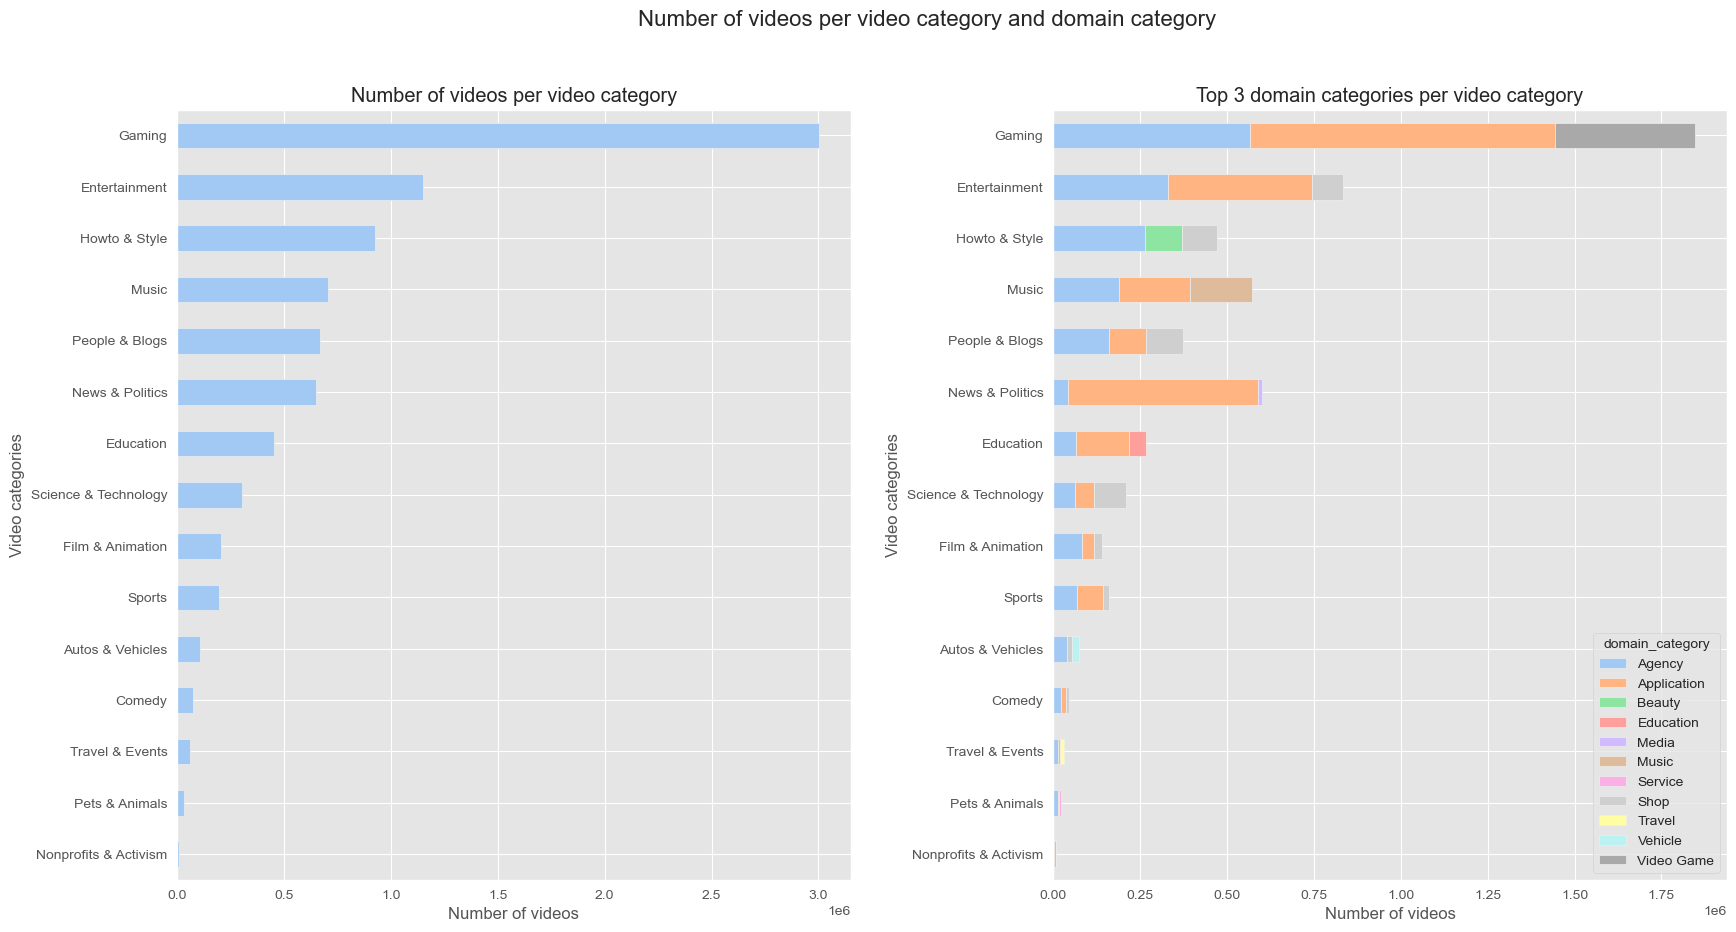

In [22]:
colors = sns.color_palette('pastel') + ['#A9A9A9']

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

video_categories_count.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlabel('Number of videos')
ax1.set_ylabel('Video categories')
ax1.set_title('Number of videos per video category')
ax1.get_legend().remove()

video_categories_top.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Number of videos')
ax2.set_ylabel('Video categories')
ax2.set_title('Top 3 domain categories per video category')

fig.suptitle('Number of videos per video category and domain category', fontsize=16)
fig.subplots_adjust(wspace=0.3)
plt.show()

The plot on the left shows us the number of sponsored videos per video category. We can see that `Gaming` is the most sponsored category of videos, followed by `Entertainment` and `Howto & Style`. 

The plot on the right shows us more information about the sponsor categories for each video category. Indeed, we can see that many videos are sponsored by `Applications` and all of them by `Agencies`. 
It is easy to spot that the video category and sponsor categories are related: the `Gaming` video category is mainly sponsored by `Video Game` sponsors which makes sense. `Entertainment` and `Howto & Style` are sponsored by `Shops`.

Also, `Howto & Style` and `People & Blogs` have suprisingly few sponsored videos on the second graph. This might indicate that these categories have a more diverse, uniform network of sponsors as many other categories not shown on this graph might be sponsoring them.

In [23]:
video_categories_total_count = all_metadatas \
    .select("categories") \
    .groupBy("categories") \
    .count() \
    .toPandas() \
    .set_index('categories') \
    .to_dict()['count']

In [24]:
video_categories_count_norm = video_categories_count \
    .apply(lambda x: x / video_categories_total_count[x.name], axis=1) \
    .sort_values(by=0, ascending=True)

In [25]:
video_categories_count_norm.head()

,0
categories,
Nonprofits & Activism,0.029495
Sports,0.101279
Autos & Vehicles,0.107100
Pets & Animals,0.132863
Travel & Events,0.133789


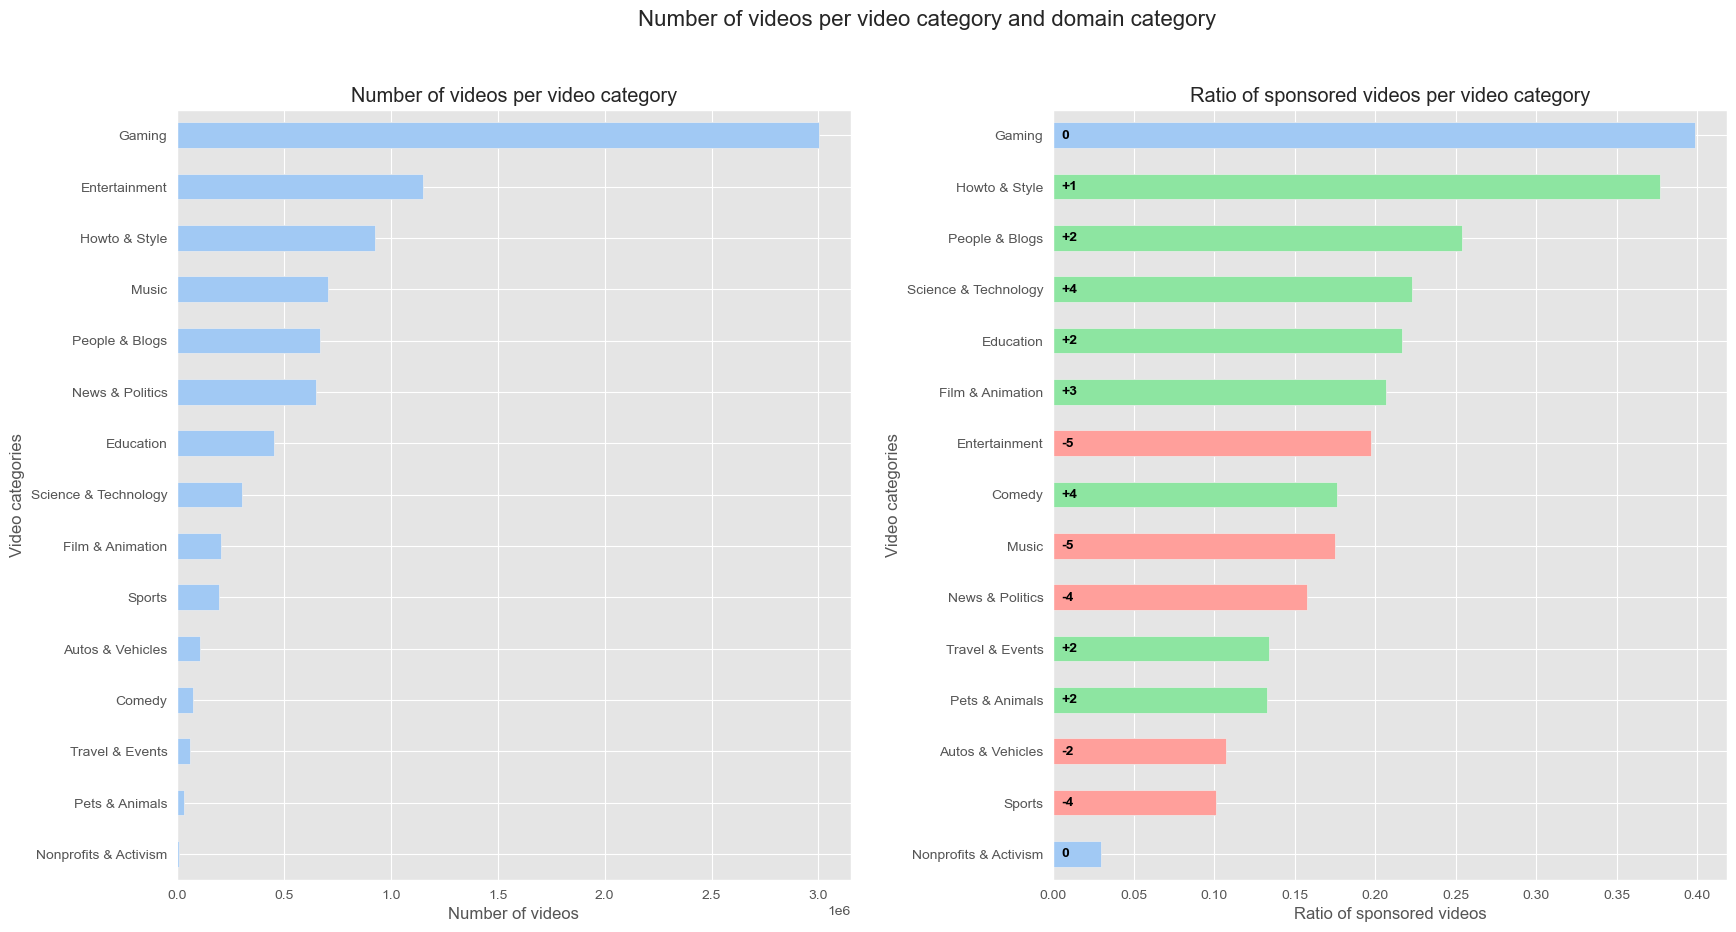

In [26]:
colors = sns.color_palette('pastel') + ['#A9A9A9']

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

video_categories_count.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlabel('Number of videos')
ax1.set_ylabel('Video categories')
ax1.set_title('Number of videos per video category')
ax1.get_legend().remove()

video_categories_count_norm.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Ratio of sponsored videos')
ax2.set_ylabel('Video categories')
ax2.set_title('Ratio of sponsored videos per video category')
ax2.get_legend().remove()

# Add ranking number of previous graph
ranking = video_categories_count[0].rank(ascending=False).astype(int).to_dict()
ranking_norm = video_categories_count_norm[0].rank(ascending=False).astype(int).to_dict()
for i, v in enumerate(video_categories_count_norm.index):
    diff = ranking[v] - ranking_norm[v]
    # Show difference between ranking
    ax2.text(0.005, i, '+'+str(diff) if diff > 0 else str(diff), color='black', va='center', fontweight='bold')
    # Change bar color depending on ranking difference
    if diff > 0:
        ax2.patches[i].set_facecolor(colors[2])
    elif diff < 0:
        ax2.patches[i].set_facecolor(colors[3])
    else:
        ax2.patches[i].set_facecolor(colors[0])

fig.suptitle('Number of videos per video category and domain category', fontsize=16)
fig.subplots_adjust(wspace=0.3)
plt.show()

The graph above shows a comparison on the number of videos per category and the ratio of sponsored videos per category. We can see that `Gaming` stays in the lead with about $40\%$ of sponsored videos. `Howto & Style` also has a high ratio of sponsored videos, but `Nonprofits & Activism` stays in the last position with very few sponsored videos.

The ratio of sponsored videos per category gives us better reasoning about the sponsorship of videos since categories are not equally represented in the dataset. We still get the same conclusion as before for some categories such as `Gaming` and `Nonprofits & Activism`, but some categories such as `Howto & Style` and `Science & Technology` come out as more sponsored than `Entertainment` and `Music`, which is quite different on the first graph.

### Sponsored vs Non-Sponsored Videos

#### Bootstrap Analysis on Features

We first apply a bootstrap analysis on the features of sponsored and non-sponsored videos.

In [27]:
all_metadatas = all_metadatas \
    .withColumn('like_view_ratio', col('like_count') / col('view_count')) \
    .withColumn('dislike_view_ratio', col('dislike_count') / col('view_count')) \
    .withColumn('like_dislike_ratio', col('like_count') / col('dislike_count'))

all_metadatas = all_metadatas \
    .where(col('like_view_ratio').isNotNull()) \
    .where(col('dislike_view_ratio').isNotNull()) \
    .where(col('like_dislike_ratio').isNotNull())

In [28]:
def bootstrap(df, column, n_bootstrap=1000, alpha=0.05, is_spark=True):
    # Get distribution values
    if is_spark:
        values = df.select(column).rdd.flatMap(lambda x: x).collect()
    else:
        values = df[column].values
    values_list = []
    values = [x for x in values if x is not None]
    n_samples = len(values)
    for i in tqdm(range(n_bootstrap)):
        values_list.append(np.mean(np.random.choice(values, n_samples, replace=True)))

    # GET CI
    values_list.sort()
    lower = int(n_bootstrap * alpha / 2)
    upper = int(n_bootstrap * (1 - alpha / 2))
    return values_list, values_list[lower], values_list[upper]

In [20]:
all_metadatas_sp = all_metadatas.where(col('is_sponsored'))
all_metadatas_nsp = all_metadatas.where(~col('is_sponsored'))

bootstrap_results = {}
bootstrap_feature_list = ['view_count', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
n_bootstrap = 1000
for feature in bootstrap_feature_list:
    bootstrap_sp, ci_sp_lower, ci_sp_upper = bootstrap(all_metadatas_sp, feature, n_bootstrap=n_bootstrap)
    bootstrap_nsp, ci_nsp_lower, ci_nsp_upper = bootstrap(all_metadatas_nsp, feature, n_bootstrap=n_bootstrap)
    # Write results to a dict
    bootstrap_results[feature] = {
        'sp': {
            'values': bootstrap_sp,
            'ci_lower': ci_sp_lower,
            'ci_upper': ci_sp_upper
        },
        'nsp': {
            'values': bootstrap_nsp,
            'ci_lower': ci_nsp_lower,
            'ci_upper': ci_nsp_upper
        }
    }

100%|██████████| 1000/1000 [16:25<00:00,  1.01it/s]


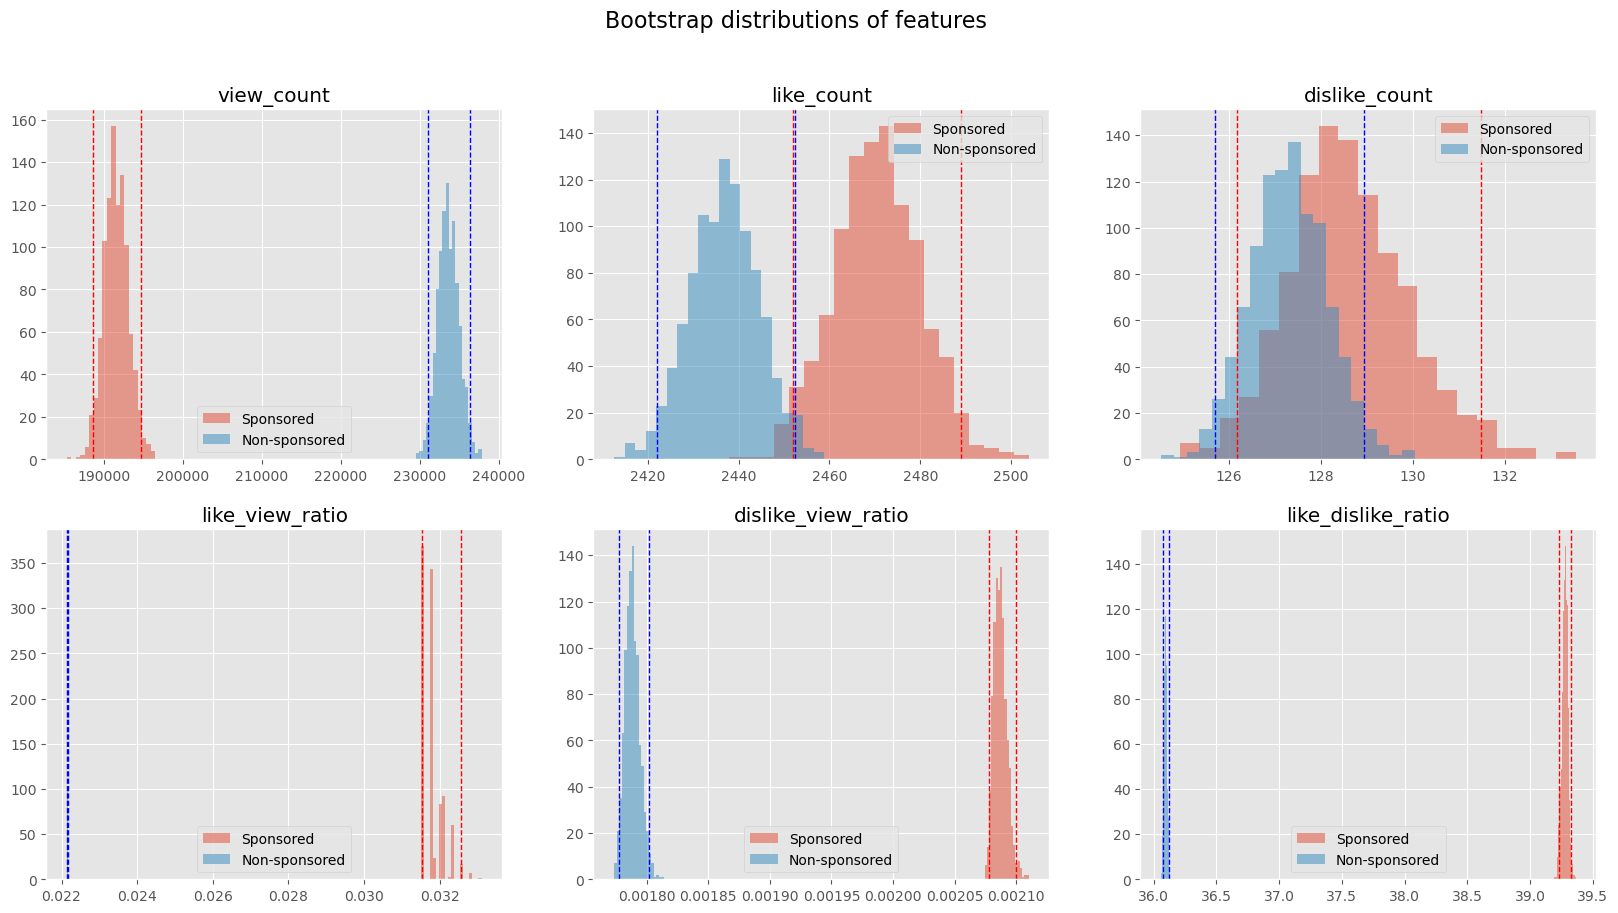

In [21]:
# plot histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(bootstrap_feature_list):
    ax = axes[i // 3, i % 3]
    ax.hist(bootstrap_results[feature]['sp']['values'], bins=20, alpha=0.5, label='Sponsored')
    ax.hist(bootstrap_results[feature]['nsp']['values'], bins=20, alpha=0.5, label='Non-sponsored')
    ax.axvline(bootstrap_results[feature]['sp']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['sp']['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_lower'], color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_upper'], color='blue', linestyle='dashed', linewidth=1)
    ax.set_title(feature)
    ax.legend()
fig.suptitle('Bootstrap distributions of features', fontsize=16)
plt.show()

The graph above shows the distributions of the mean of features using bootstrap analysis for some features related to the popularity and the appreciation of videos. Interestingly, the first plot shows us that **sponsored video tend to have a lower number of views than non-sponsored videos**, about $15\%$ less! Nevertheless, sponsored videos tend to have a **higher reaction count**, with more like and dislikes on average than non-sponsored videos. The ratio of likes to dislikes is also higher for sponsored videos!

The first result is quite surprising since we would expect sponsored videos to have a higher number of views as sponsors may target videos with a higher potential of being popular. But this result may be explained by the fact that many confounding factors may influence the popularity of a video in each group. For example, non-sponsored videos might consist in many music videos, which tend to have a huge view count as they are listened to by many people and automatic playlists multiple times. Also, media channels might publish unsponsored videos with a high view count.

The second finding could be expected, but might also be explained by external factors. For example the Gaming industry, dominating sponsored videos from our past findings, might be more competitive than others video categories. They might ask for more engagement and form strong communities around their content, asking for likes and reactions. The like to view and dislike to view rations might be higher for that reason.

#### T-tests on Sponsored Videos

In [22]:
# Apply t-tests for each feature
ttest_results = {}
for feature in bootstrap_feature_list:
    ttest_results[feature] = ttest_ind(
        bootstrap_results[feature]['sp']['values'],
        bootstrap_results[feature]['nsp']['values'],
        equal_var=False
    )

# print results
for feature in bootstrap_feature_list:
    print(f'{feature}: {ttest_results[feature]}')

view_count: Ttest_indResult(statistic=-650.6261659967737, pvalue=0.0)
like_count: Ttest_indResult(statistic=87.61528983510382, pvalue=0.0)
dislike_count: Ttest_indResult(statistic=26.4048332691145, pvalue=7.84949660855777e-129)
like_view_ratio: Ttest_indResult(statistic=1120.9452322288612, pvalue=0.0)
dislike_view_ratio: Ttest_indResult(statistic=1154.8658549256202, pvalue=0.0)
like_dislike_ratio: Ttest_indResult(statistic=3788.1834709499617, pvalue=0.0)


The t-tests also show us that **sponsored and non-sponsored videos have significant differences on the analysed features**. The p-values are almost all equal to $0$, meaning that we can reject the null hypothesis that the means of the two groups are equal.

#### Matching Analysis on Sponsored Videos

To avoid the possible bias caused by confounding factors in our previous analysis, we perform a matching analysis. We match sponsored and non-sponsored videos based on some rules:

- The videos should have the same category.
- The videos should not come from the same channel.
- The videos should have the same order of magnitude of views.
- The videos should be posted on the same month.
- The videos should have the same approximate length ($10$ minutes difference maximum).

We perform our analysis on a random sample of $1\%$ of the entire dataset.

In [20]:
SAMPLE_FRACTION = 0.01
SAMPLE_SEED = 0

# Generate the subsample
all_metadatas_sub = all_metadatas \
    .sample(False, SAMPLE_FRACTION, seed=SAMPLE_SEED) \
    .select('categories', 'channel_id', 'view_count', 'diff_month', 'duration', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio', 'is_sponsored') \
    .toPandas()

In [22]:
DURATION_BIN_SIZE = 60 * 10

G = nk.graph.Graph(n=len(all_metadatas_sub), weighted=False, directed=False)

# Add edges on non-sponsored exact matches for every sponsored video
for sp_id, sp_row in tqdm(all_metadatas_sub[all_metadatas_sub.is_sponsored].iterrows()):
    category = sp_row['categories']
    channel_id = sp_row['channel_id']
    log_view_count = np.floor(np.log(sp_row['view_count']))
    diff_month = sp_row['diff_month']
    duration = sp_row['duration']
    exact_matched = all_metadatas_sub[
        (all_metadatas_sub.categories == category) &
        (all_metadatas_sub.channel_id != channel_id) &
        (np.floor(np.log(all_metadatas_sub.view_count)) == log_view_count) &
        (all_metadatas_sub.diff_month == diff_month) &
        (np.abs(all_metadatas_sub.duration - duration) < DURATION_BIN_SIZE) &
        (~all_metadatas_sub.is_sponsored)
    ]
    for nps_id, nsp_row in exact_matched.iterrows():
        G.addEdge(sp_id, nps_id)

57468it [18:42, 51.21it/s]


In [23]:
print(f'Number of nodes: {G.numberOfNodes()}')
print(f'Number of edges: {G.numberOfEdges()}')

Number of nodes: 256159
Number of edges: 1679887


In [24]:
# Perform a linear time 1/2-approximation of the maximum matching.
matcher = nk.matching.PathGrowingMatcher(G).run()
matching = matcher.getMatching()

In [25]:
matching_pairs = []
for u in G.iterNodes():
    if matching.isMatched(u) and u < matching.mate(u):
        matching_pairs.append((u, matching.mate(u)))
len(matching_pairs)

45656

In [31]:
# Get a new dataframe with the matched pairs
matching_df = pd.DataFrame(matching_pairs, columns=['sp_id', 'nsp_id'])
matching_df = matching_df.merge(all_metadatas_sub, left_on='sp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .merge(all_metadatas_sub, left_on='nsp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .drop(['sp_id', 'nsp_id'], axis=1)

# Separate the matched pairs
all_matching = np.asarray([[m[0], m[1]] for m in matching_pairs]).flatten().tolist()
all_matching_df = all_metadatas_sub[all_metadatas_sub.index.isin(all_matching)].copy()
all_matching_df['is_sponsored'] = all_matching_df['is_sponsored'].astype(int)

all_matching_df

,categories,channel_id,view_count,diff_month,duration,like_count,dislike_count,like_view_ratio,dislike_view_ratio,like_dislike_ratio,is_sponsored
1,Entertainment,UCjWIUN8EfDV5b09FHMngD0A,50953,155,1700,2802,48,0.054992,0.000942,58.375000,0
5,Entertainment,UCGydrkfIhUDNCotYQI8TJhA,43817,135,93,152,42,0.003469,0.000959,3.619048,0
6,News & Politics,UC3k3floOm_HtKOv0l6JU-xQ,2269,139,354,70,2,0.030851,0.000881,35.000000,0
8,Gaming,UCsDtTzkvGxxw95C4IOfZ7dw,101313,124,1974,2467,55,0.024350,0.000543,44.854545,1
9,News & Politics,UCl5YgCiwSRVOiC2Nd1P9v1A,9781,168,303,92,12,0.009406,0.001227,7.666667,0
...,...,...,...,...,...,...,...,...,...,...,...
256115,Entertainment,UCnkQvzIGTYodVwU9BLnYWWA,508,168,213,22,1,0.043307,0.001969,22.000000,1
256119,Music,UCaOWPFOz0xlEN6z4a7RNT5g,3303,105,148,26,3,0.007872,0.000908,8.666667,1
256133,Gaming,UCRziS4QyZ1VZIfeolPcOS5A,4124,148,219,56,9,0.013579,0.002182,6.222222,1
256146,Sports,UCV_kZ4gveK8fVEfTWWVGSgw,102908,145,446,368,246,0.003576,0.002390,1.495935,1


like_count:
	Intercept: 1559.075017522343 with p-value 0.0
	Sponsored: 123.28123357280742 with p-value 0.023059436068326777
	R-squared: 5.655354695610626e-05
dislike_count:
	Intercept: 70.77832048361633 with p-value 3.042690374320046e-36
	Sponsored: 9.031868757666016 with p-value 0.2564542786032538
	R-squared: 1.4103551238098255e-05
like_view_ratio:
	Intercept: 0.026331118989094827 with p-value 0.0
	Sponsored: 0.004375507199508967 with p-value 1.1427541578720109e-140
	R-squared: 0.006957918255264817
dislike_view_ratio:
	Intercept: 0.001614170867591669 with p-value 0.0
	Sponsored: 0.00023382121688327392 with p-value 3.011788795650553e-18
	R-squared: 0.0008306931371387938
like_dislike_ratio:
	Intercept: 40.136783421314064 with p-value 0.0
	Sponsored: 0.6689996463788273 with p-value 0.06879459507076298
	R-squared: 3.626664802869328e-05


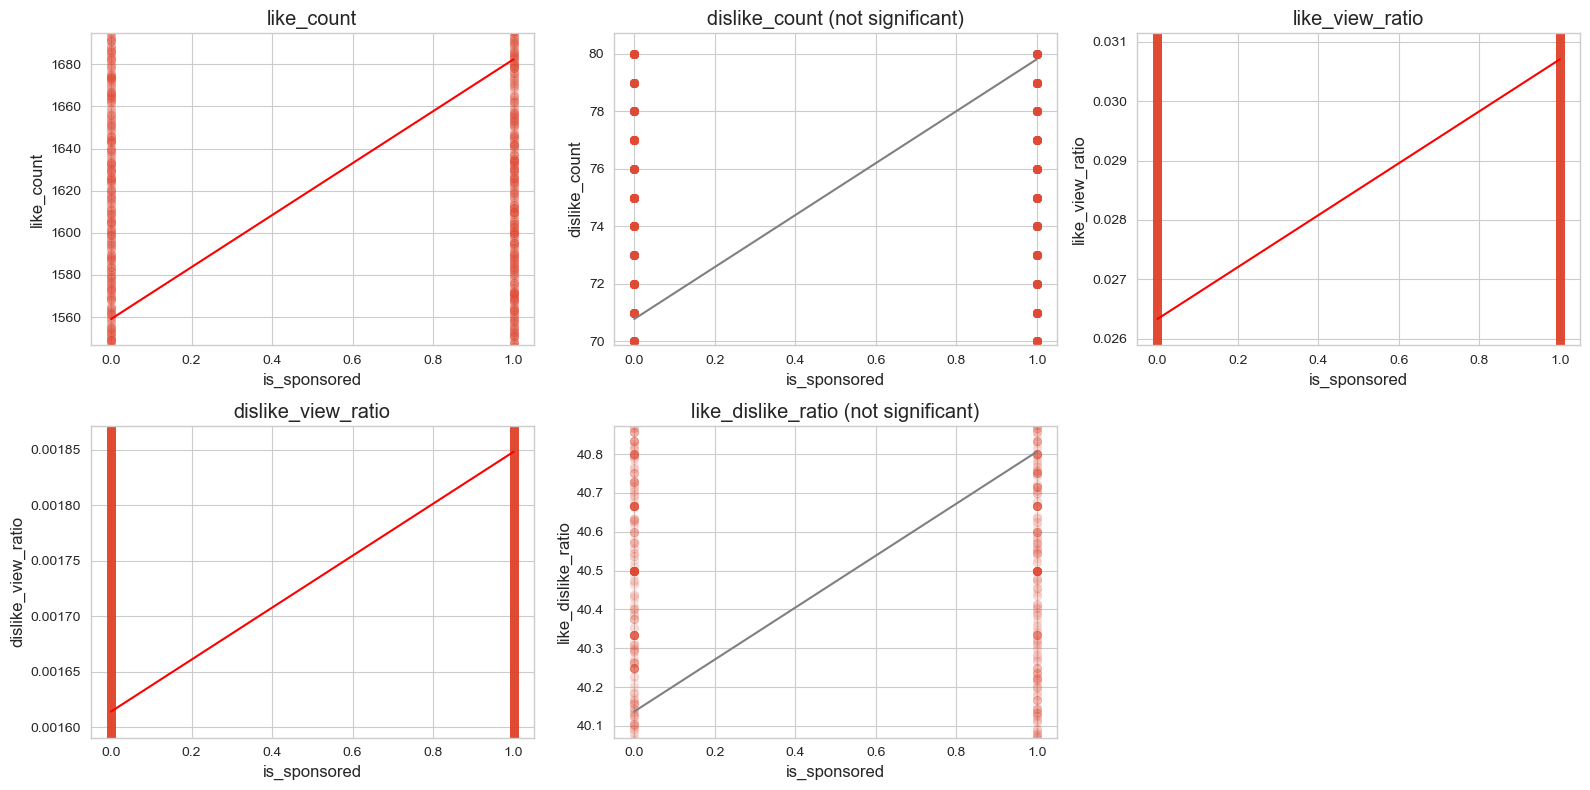

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

feature_list = ['like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
for i, feature in enumerate(feature_list):
    mod = smf.ols(formula=f'{feature} ~ C(is_sponsored)', data=all_matching_df)
    res = mod.fit()
    print(f'{feature}:')
    print(f'\tIntercept: {res.params[0]} with p-value {res.pvalues[0]}')
    print(f'\tSponsored: {res.params[1]} with p-value {res.pvalues[1]}')
    print(f'\tR-squared: {res.rsquared}')

    ax = axes[i // 3, i % 3]
    X = [0, 1]
    y = [res.params[0], res.params[0] + res.params[1]]
    ax.plot(X, y, color='red' if res.pvalues[1] < 0.05 else 'gray')
    ax.scatter(all_matching_df['is_sponsored'], all_matching_df[feature], alpha=0.1)
    ax.set_title(feature)
    ax.set_xlabel('is_sponsored')
    ax.set_ylabel(feature)
    # zoom only on interesting parts
    y_1 = res.params[0] - res.params[1] / 10
    y_2 = res.params[0] + res.params[1] + res.params[1] / 10
    ax.set_ylim(min(y_1, y_2), max(y_1, y_2))
    if res.pvalues[1] > 0.05:
        ax.set_title(feature + ' (not significant)')

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


Finally, we perform a regression analysis on the matched elements. The results are shown above. The `like_count` has an intercept of $1559$, which means that the mean of the number of likes for non-sponsored videos is $1559$. Sponsored users have $123$ more likes on average, with statistical significance! In this analysis, we also conclude that **sponsored videos have a higher number of likes**.

But we were not able to conclude anything about the number of dislikes. Indeed, non-sponsored videos have about $70$ dislikes, but the slope of the regression is not significant. This might be explained by the fact that the number of dislikes is very low for both groups, and the confidence interval is very large.

The ratio of likes per view seem to be higher for sponsored videos, sponsored videos have on average an increase of $\frac{0.0043}{0.0263} * 100 = 16\%$ of likes per view, with statistical significance.

Interestingly enough, the number of dislikes per view is also higher for sponsored videos, with an increase of $\frac{0.00023}{0.0016} * 100 = 14\%$ of dislikes per view, with statistical significance.

This could be explained by two things: 
- In the matching, we matched videos with the same order of magnitude of views, but in our previous analysis, we saw that sponsored videos had on average a lower number of views. This tendency could also slightly appear in this analysis, which would explain the increase of likes and dislikes per view.
- The second explanation would be that sponsored videos are more engaging towards the audience. Sponsored YouTubers might ask for more likes and reactions as their revenue is based on the popularity of their videos.

We will check if the first explanation is true using a bootrapping approach.

100%|██████████| 10000/10000 [00:13<00:00, 745.15it/s]


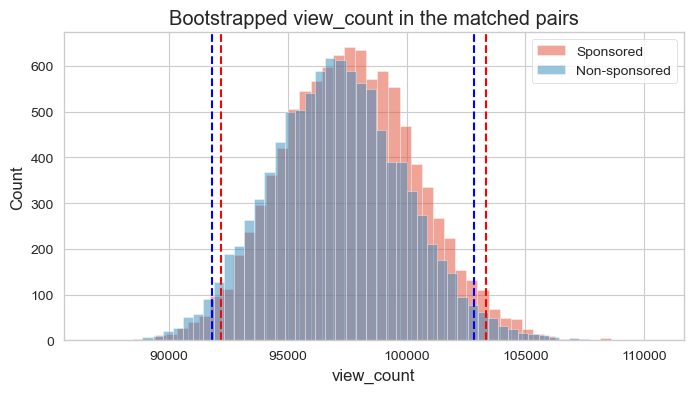

In [63]:
all_matching_sp = all_matching_df[all_matching_df.is_sponsored == 1]
all_matching_nsp = all_matching_df[all_matching_df.is_sponsored == 0]

# Bootstrap
n_bootstrap = 10000
bootstrap_sp, ci_sp_lower, ci_sp_upper = bootstrap(all_matching_sp, 'view_count', n_bootstrap=n_bootstrap, is_spark=False)
bootstrap_nsp, ci_nsp_lower, ci_nsp_upper = bootstrap(all_matching_nsp, 'view_count', n_bootstrap=n_bootstrap, is_spark=False)

# Plot histograms
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(bootstrap_sp, bins=50, alpha=0.5, label='Sponsored')
ax.hist(bootstrap_nsp, bins=50, alpha=0.5, label='Non-sponsored')
ax.axvline(ci_sp_lower, color='red', linestyle='--')
ax.axvline(ci_sp_upper, color='red', linestyle='--')
ax.axvline(ci_nsp_lower, color='blue', linestyle='--')
ax.axvline(ci_nsp_upper, color='blue', linestyle='--')
ax.set_title('Bootstrapped view_count in the matched pairs')
ax.set_xlabel('view_count')
ax.set_ylabel('Count')
ax.legend()
plt.show()

The matching captured an interesting finding, since both sponsored and non-sponsored seem to follow a very similar trend: the first explanation seems to be false!

In [67]:
bootstrap_results = {}
bootstrap_feature_list = ['view_count', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
n_bootstrap = 10000
for feature in bootstrap_feature_list:
    bootstrap_sp, ci_sp_lower, ci_sp_upper = bootstrap(all_matching_sp, feature, n_bootstrap=n_bootstrap, is_spark=False)
    bootstrap_nsp, ci_nsp_lower, ci_nsp_upper = bootstrap(all_matching_nsp, feature, n_bootstrap=n_bootstrap, is_spark=False)
    # Write results to a dict
    bootstrap_results[feature] = {
        'sp': {
            'values': bootstrap_sp,
            'ci_lower': ci_sp_lower,
            'ci_upper': ci_sp_upper
        },
        'nsp': {
            'values': bootstrap_nsp,
            'ci_lower': ci_nsp_lower,
            'ci_upper': ci_nsp_upper
        }
    }

100%|██████████| 10000/10000 [00:13<00:00, 722.79it/s]


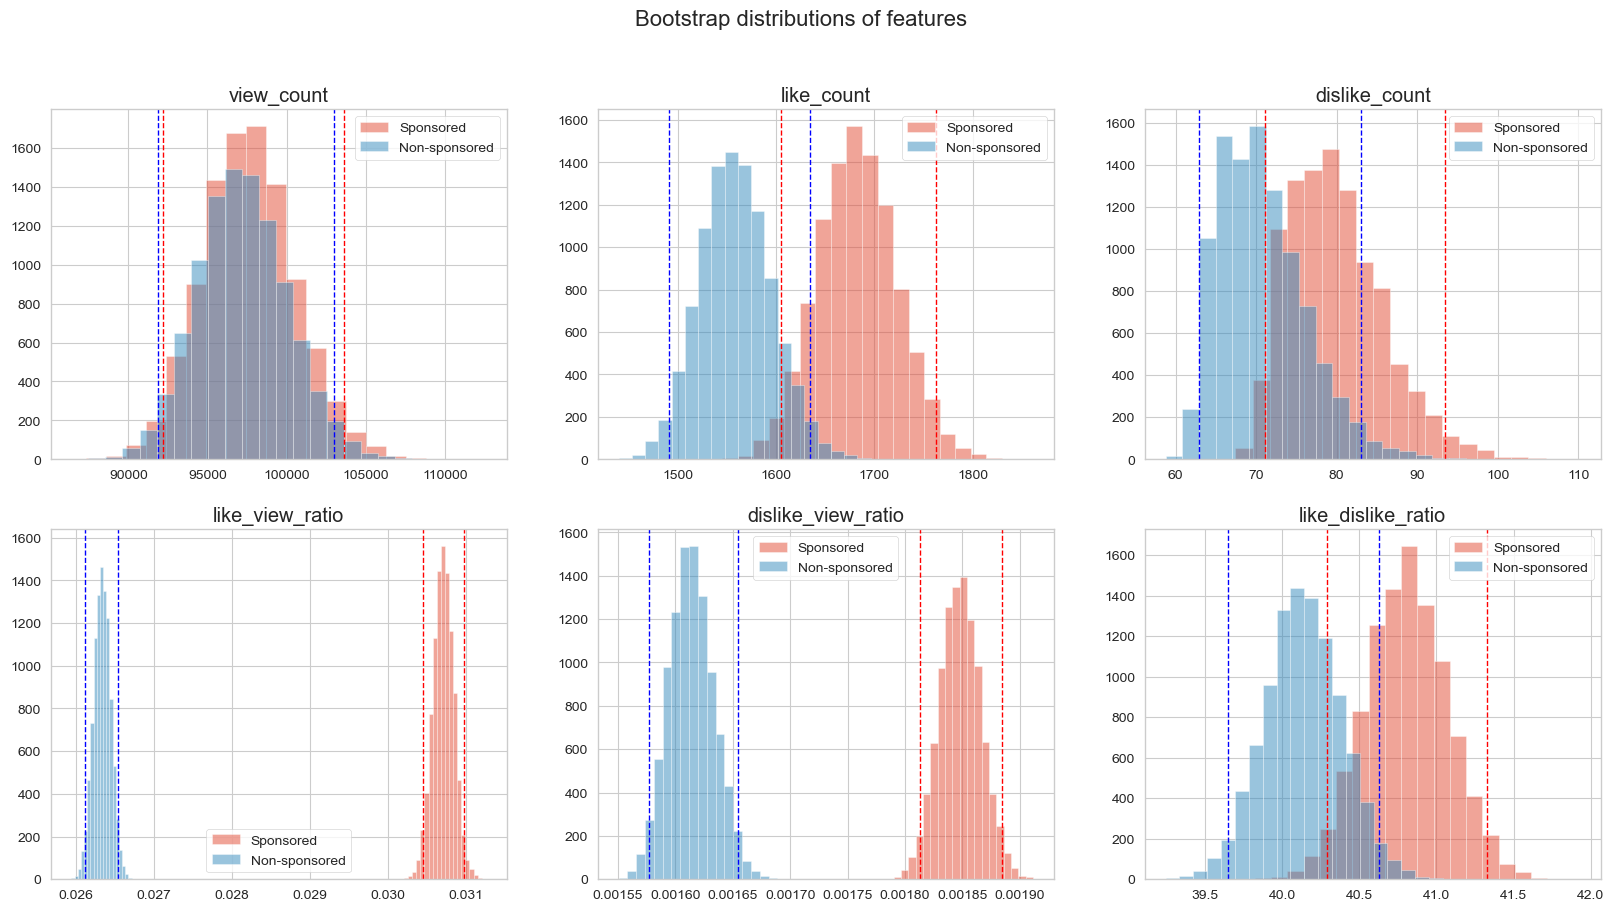

In [68]:
# plot histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(bootstrap_feature_list):
    ax = axes[i // 3, i % 3]
    ax.hist(bootstrap_results[feature]['sp']['values'], bins=20, alpha=0.5, label='Sponsored')
    ax.hist(bootstrap_results[feature]['nsp']['values'], bins=20, alpha=0.5, label='Non-sponsored')
    ax.axvline(bootstrap_results[feature]['sp']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['sp']['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_lower'], color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_upper'], color='blue', linestyle='dashed', linewidth=1)
    ax.set_title(feature)
    ax.legend()
fig.suptitle('Bootstrap distributions of features', fontsize=16)
plt.show()

This plot shows the same histograms as before, but only taking into account the matched videos. The `view_count` is similar since it appears in our exact matching rules, and the confidence intervals show us approximately the same results as before. We can see that both confidence intervals for the `dislike_count` are overlapping, but we can still notice a trend: the number of dislikes seems to be higher for sponsored videos. 

### Agencied vs Non-Agencied Videos

#### Matching Analysis on Agencied Videos

In this section, we perform the same analysis steps as before, but focusing on the agencies. We match videos sponsored by agencies and sponsored videos that are not sponsored by agencies. We perform our analysis on a random sample of $2\%$ of the entire dataset.

In [31]:
SAMPLE_FRACTION = 0.02
SAMPLE_SEED = 0

# Generate the subsample
all_metadatas_sub = all_metadatas \
    .sample(False, SAMPLE_FRACTION, seed=SAMPLE_SEED) \
    .select('categories', 'channel_id', 'view_count', 'diff_month', 'duration', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio', 'domain_categories', 'is_sponsored') \
    .toPandas()

# Add has_agency feature
all_metadatas_sub['has_agency'] = all_metadatas_sub.apply(lambda row: 'Agency' in row['domain_categories'], axis=1)
all_metadatas_sub = all_metadatas_sub.drop(['domain_categories'], axis=1)

In [32]:
DURATION_BIN_SIZE = 60 * 10

G = nk.graph.Graph(n=len(all_metadatas_sub), weighted=False, directed=False)

# Add edges on non-sponsored exact matches for every sponsored video
for sp_id, sp_row in tqdm(all_metadatas_sub[all_metadatas_sub.has_agency].iterrows()):
    channel_id = sp_row['channel_id']
    log_view_count = np.floor(np.log(sp_row['view_count']))
    diff_month = sp_row['diff_month']
    duration = sp_row['duration']
    exact_matched = all_metadatas_sub[
        (all_metadatas_sub.channel_id != channel_id) &
        (np.floor(np.log(all_metadatas_sub.view_count)) == log_view_count) &
        (all_metadatas_sub.diff_month == diff_month) &
        (np.abs(all_metadatas_sub.duration - duration) < DURATION_BIN_SIZE) &
        (~all_metadatas_sub.has_agency) &
        (all_metadatas_sub.is_sponsored)
    ]
    for nps_id, nsp_row in exact_matched.iterrows():
        G.addEdge(sp_id, nps_id)

31360it [11:38, 44.93it/s]


In [33]:
print(f'Number of nodes: {G.numberOfNodes()}')
print(f'Number of edges: {G.numberOfEdges()}')

Number of nodes: 511959
Number of edges: 3429744


In [34]:
# Perform a linear time 1/2-approximation of the maximum matching.
matcher = nk.matching.PathGrowingMatcher(G).run()
matching = matcher.getMatching()

In [35]:
matching_pairs = []
for u in G.iterNodes():
    if matching.isMatched(u) and u < matching.mate(u):
        matching_pairs.append((u, matching.mate(u)))
len(matching_pairs)

29019

In [36]:
# Get a new dataframe with the matched pairs
matching_df = pd.DataFrame(matching_pairs, columns=['sp_id', 'nsp_id'])
matching_df = matching_df.merge(all_metadatas_sub, left_on='sp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .merge(all_metadatas_sub, left_on='nsp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .drop(['sp_id', 'nsp_id'], axis=1)

# Separate the matched pairs
all_matching = np.asarray([[m[0], m[1]] for m in matching_pairs]).flatten().tolist()
all_matching_df = all_metadatas_sub[all_metadatas_sub.index.isin(all_matching)].copy()
all_matching_df['has_agency'] = all_matching_df['has_agency'].astype(int)

all_matching_df

,categories,channel_id,view_count,diff_month,duration,like_count,dislike_count,like_view_ratio,dislike_view_ratio,like_dislike_ratio,is_sponsored,has_agency
1,Music,UC5I3vUh2iNfQ3pCU3sodYRA,3799,160,2958,134,4,0.035272,0.001053,33.500000,True,0
12,Music,UCH8zETBh4ZBW8FSEObTpVGA,44312,148,202,811,11,0.018302,0.000248,73.727273,True,0
15,Gaming,UCsDtTzkvGxxw95C4IOfZ7dw,101313,124,1974,2467,55,0.024350,0.000543,44.854545,True,1
18,Music,UC22nIfOTM7KLIQuFGMKzQbg,547911,141,258,291,126,0.000531,0.000230,2.309524,True,0
26,Gaming,UCQpCAElRwC5kb6oyXoBxApw,1368,149,180,39,3,0.028509,0.002193,13.000000,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
511780,Entertainment,UC3ldAyWZqlLdSh5EyxX2EbQ,2196,161,949,249,1,0.113388,0.000455,249.000000,True,1
511797,Howto & Style,UCGIaiz5OLxlfuH9gkqbejnQ,195403,167,380,8010,123,0.040992,0.000629,65.121951,True,1
511839,Howto & Style,UCPKAKrjoMz7POptCloy7AIQ,29313,142,379,605,10,0.020639,0.000341,60.500000,True,1
511873,Music,UCaOWPFOz0xlEN6z4a7RNT5g,3303,105,148,26,3,0.007872,0.000908,8.666667,True,1


like_count:
	Intercept: 1867.2136186636665 with p-value 5.649729435926451e-198
	Agency: 195.85905785857835 with p-value 0.025409581566262763
	R-squared: 8.607729608434145e-05
dislike_count:
	Intercept: 84.92284365415891 with p-value 4.3391539943880096e-203
	Agency: -8.578276301736146 with p-value 0.029216009002074484
	R-squared: 8.192649701754817e-05
like_view_ratio:
	Intercept: 0.02845618213026577 with p-value 0.0
	Agency: 0.00790421013410051 with p-value 2.812391024998201e-258
	R-squared: 0.020102431363766327
dislike_view_ratio:
	Intercept: 0.0018099611007482213 with p-value 0.0
	Agency: -6.09413686414023e-05 with p-value 0.05508853812935607
	R-squared: 6.339718588987964e-05
like_dislike_ratio:
	Intercept: 38.06315645404012 with p-value 0.0
	Agency: 9.736438878143145 with p-value 1.8276578185222812e-94
	R-squared: 0.007299283307704574


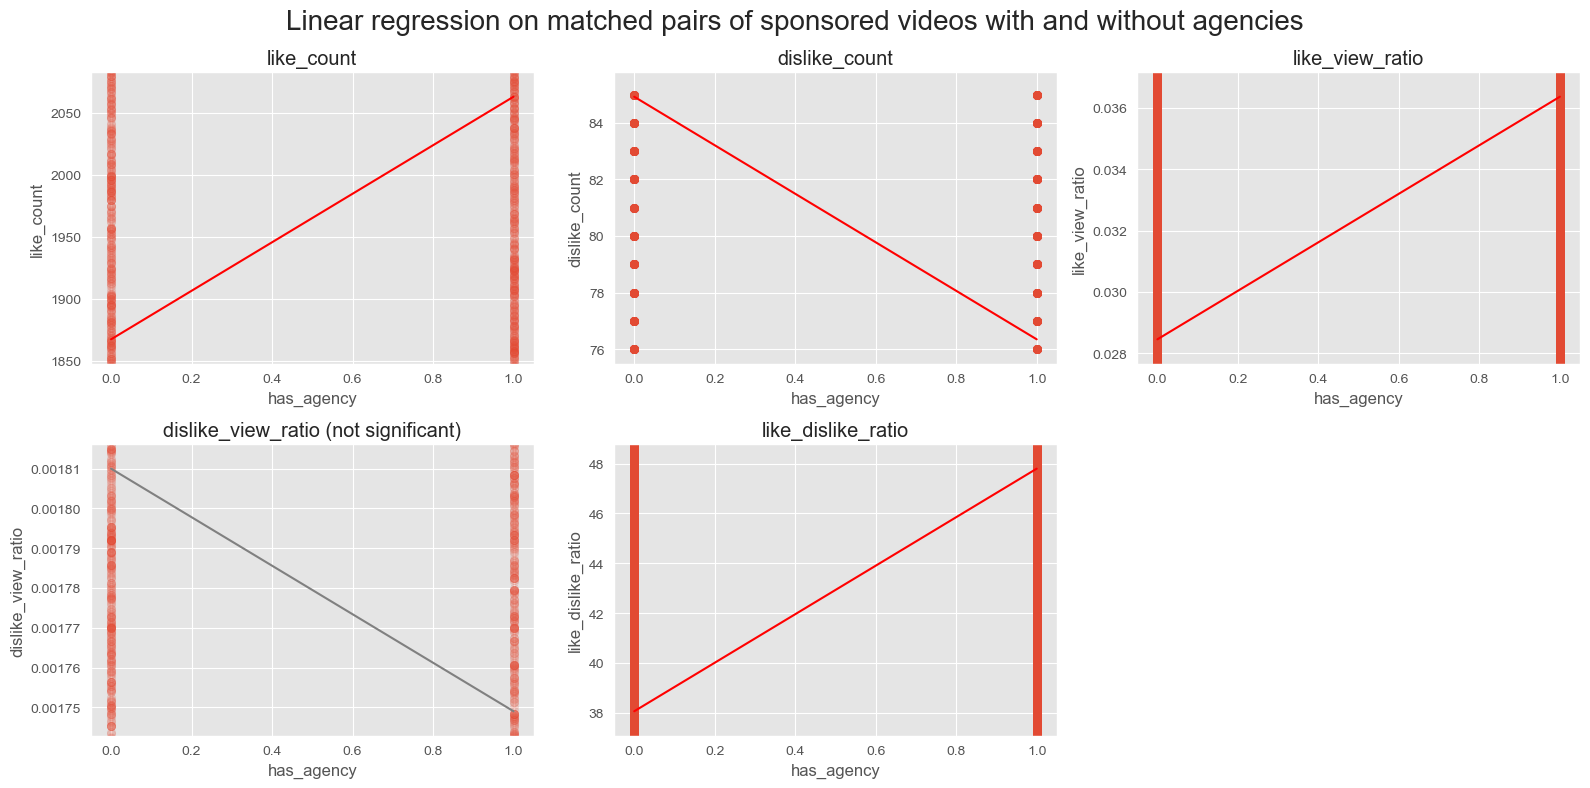

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

feature_list = ['like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
for i, feature in enumerate(feature_list):
    mod = smf.ols(formula=f'{feature} ~ C(has_agency)', data=all_matching_df)
    res = mod.fit()
    print(f'{feature}:')
    print(f'\tIntercept: {res.params[0]} with p-value {res.pvalues[0]}')
    print(f'\tAgency: {res.params[1]} with p-value {res.pvalues[1]}')
    print(f'\tR-squared: {res.rsquared}')

    ax = axes[i // 3, i % 3]
    X = [0, 1]
    y = [res.params[0], res.params[0] + res.params[1]]
    ax.plot(X, y, color='red' if res.pvalues[1] < 0.05 else 'gray')
    ax.scatter(all_matching_df['has_agency'], all_matching_df[feature], alpha=0.1)
    ax.set_title(feature)
    ax.set_xlabel('has_agency')
    ax.set_ylabel(feature)
    # zoom only on interesting parts
    y_1 = res.params[0] - res.params[1] / 10
    y_2 = res.params[0] + res.params[1] + res.params[1] / 10
    ax.set_ylim(min(y_1, y_2), max(y_1, y_2))
    if res.pvalues[1] > 0.05:
        ax.set_title(feature + ' (not significant)')

fig.delaxes(axes[1, 2])
fig.suptitle('Linear regression on matched pairs of sponsored videos with and without agencies', fontsize=20)
plt.tight_layout()
plt.show()


The above plots show the regression analysis on the matched elements. The treatment group is sponsored by an agency, whereas the control group is not. We can see that videos sponsored by agencies have a **higher number of likes and a lower number of dislikes**! They also have a **higher ratio of likes per view** and a **higher like/dislike ratio**.

All of these results are positive towards the videos sponsored by agencies. They seem to be more engaging, with a more likes and less dislikes. This could be explained by the fact that agencies are more professional and have more experience in the field of marketing and advertising. They might be able to target the right audience and create more engaging content.

In [38]:
all_matching_ag = all_matching_df[all_matching_df.has_agency == 1]
all_matching_nag = all_matching_df[all_matching_df.has_agency == 0]

bootstrap_results = {}
bootstrap_feature_list = ['view_count', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
n_bootstrap = 10000
for feature in bootstrap_feature_list:
    bootstrap_ag, ci_ag_lower, ci_ag_upper = bootstrap(all_matching_ag, feature, n_bootstrap=n_bootstrap, is_spark=False)
    bootstrap_nag, ci_nag_lower, ci_nag_upper = bootstrap(all_matching_nag, feature, n_bootstrap=n_bootstrap, is_spark=False)
    # Write results to a dict
    bootstrap_results[feature] = {
        'ag': {
            'values': bootstrap_ag,
            'ci_lower': ci_ag_lower,
            'ci_upper': ci_ag_upper
        },
        'nag': {
            'values': bootstrap_nag,
            'ci_lower': ci_nag_lower,
            'ci_upper': ci_nag_upper
        }
    }

100%|██████████| 10000/10000 [00:07<00:00, 1252.16it/s]


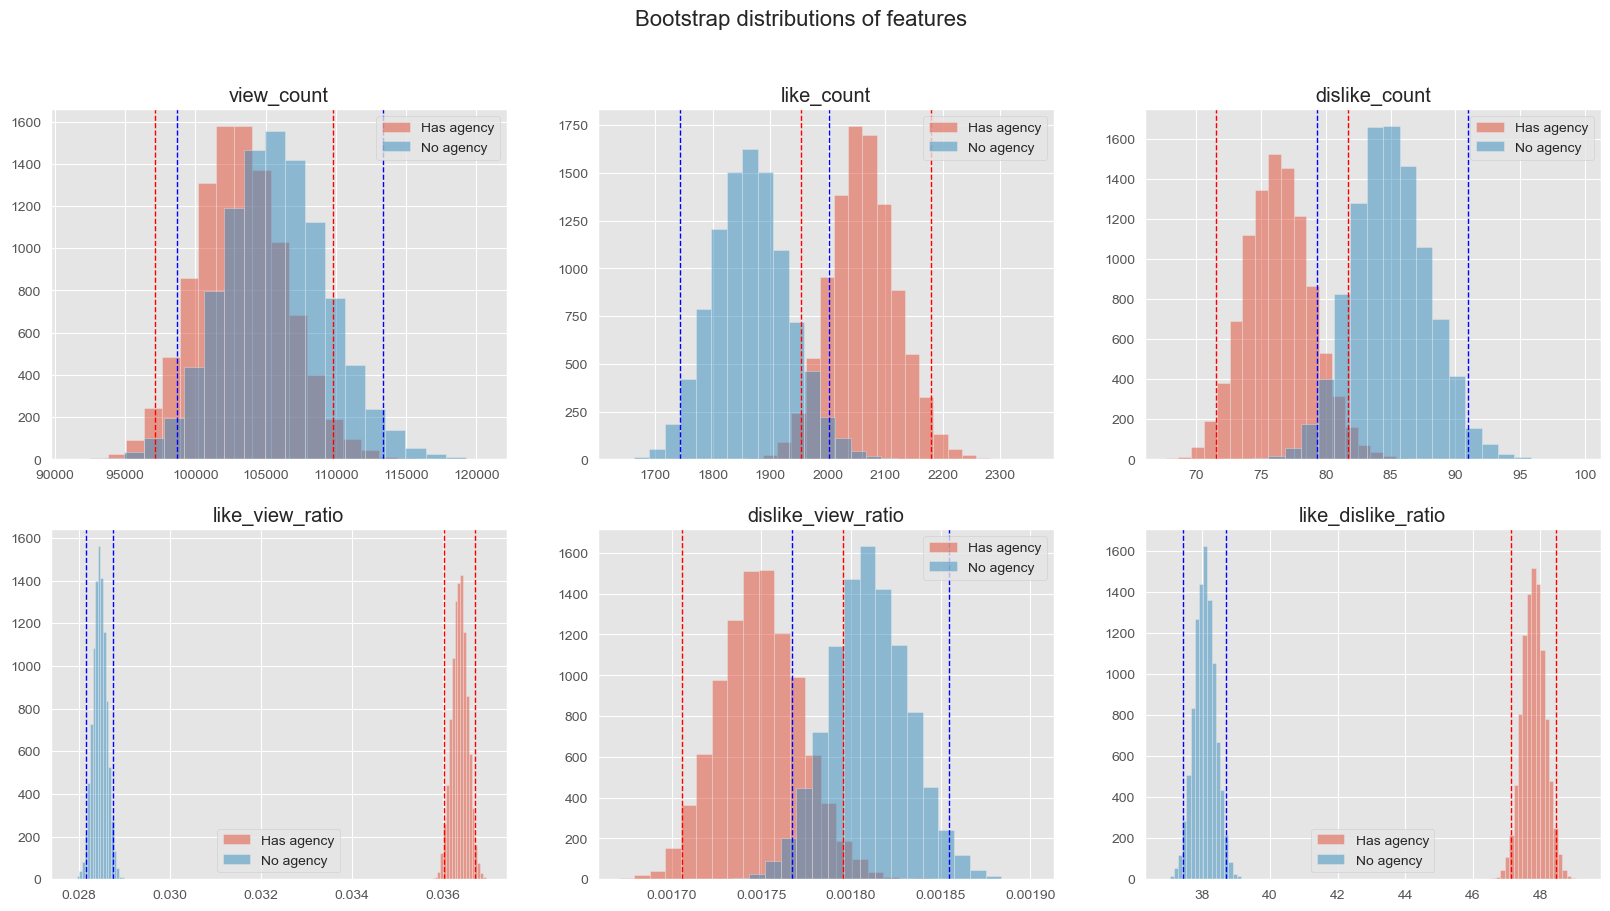

In [40]:
# plot histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(bootstrap_feature_list):
    ax = axes[i // 3, i % 3]
    ax.hist(bootstrap_results[feature]['ag']['values'], bins=20, alpha=0.5, label='Has agency')
    ax.hist(bootstrap_results[feature]['nag']['values'], bins=20, alpha=0.5, label='No agency')
    ax.axvline(bootstrap_results[feature]['ag']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['ag']['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nag']['ci_lower'], color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nag']['ci_upper'], color='blue', linestyle='dashed', linewidth=1)
    ax.set_title(feature)
    ax.legend()
fig.suptitle('Bootstrap distributions of features', fontsize=16)
plt.show()

This plot shows the same histograms as before, taking into account the matched sponsored videos with and without agencies. Comparing the two, the like to dislike ratio seems to be approximately the same, but videos with agencies have less dislikes with statistical significance. The dislike to view ratio emphasizes the same conclusion, with a lower ratio for videos with agencies.

Also, the like to dislike ration are completely different, with videos agencies having an increase of $1 - \frac{46}{36} * 100 = 28\%$ of likes per dislike, with statistical significance. 